<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# 1.  [High Dimensional and Deep Learning](https://github.com/wikistat/High-Dimensional-Deep-Learning ):  [Reconnaissance d'Activité Humaine](https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/FunctionalDecomposition/Python%20-%20HAR.ipynb) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a>   Anomaly Detection

## 1.1 Context


The objective is to recognize the activity of an individual from a set of signals recorded on a smartphone from the embedded gyroscope and accelerometer. A learning database has been built experimentally. A set of persons  performed a determined activity for a predefined period of time while signals were recorded. The data come from the community that aims to recognize human activities (Human activity recognition, HAR). See the [paper](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) on a symposium in 2013. The analysis of data associated with real-time activity identification is not discussed.

The available public data was acquired, described and partly analyzed by [Anguita et al. (2013)](https://www.icephd.org/sites/default/files/IWAAL2012.pdf). They are available on the University California Irvine (UCI) [repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dedicated to machine learning.

The archive contains the raw data: accelerations sampled at 64 htz during 2s. The accelerations in x, y, and z (body_acc), each contains 128 columns, those by subtracting the natural gravity (total_acc) as well as the angular accelerations in x, y, and z obtained from the gyroscope (body_gyro). The choice of a power of 2 for the sampling frequency allows the efficient execution of Fourier transform or wavelet transform algorithms.


The *features data* have been built by experts of signal processing from the *a priori* knowledge on the behaviour of the different activities we want to study. We will see that it is quite easy to achieve good performances for the anomaly detection problem using these features data.


The objective of this TP is to detect anomalies from the *features* data and from simple transformations of the raw data. 

## 1.2 Objectives : 

- Apply several anomaly detection methods on the *features* data :  
  - Hierarchical clustering (CAH : Classification ascendante hiérarchique)
  - One-class SVM
  - Local Outlier Factor
  - Isolation Forest
  
 
- Anomaly detection on the functional data : transformation of the raw data onto new features (PCA, wavelet decomposition, Fast Fourier Transform) on which we apply the previous mentioned anomaly detection methods.


- As in the previous TP for classification purposes, the objective is here to obtain as good performances for anomaly detection as on  the *features* data with simple transformations of the raw signals. 


# 2. Introduction

## 2.1 Libraries

In [1]:
import pandas as pd
import numpy as np

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
import utils.illustration as uil
import utils.load as ul

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

In [2]:
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z"]
CMAP = plt.get_cmap("Set1")
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}
COLOR_DIC = {v:CMAP(k-2) if v!="WALKING" else CMAP(10) for k,v in ACTIVITY_DIC.items()}

## 2.2  The data
### 2.2.1 Loading the data


In [3]:
data_path = "../data/HumanActivityRecognition/"
#Multidimensional Data
X_train = ul.load_signals(data_path,"train", SIGNALS)
Y_train_label=ul.my_read_csv(data_path+"train/y_train.txt")[0]
X_train_metier= ul.my_read_csv(data_path+"/train/X_train.txt").values

In [155]:
X_test = ul.load_signals(data_path,"test", SIGNALS)
Y_test_label=ul.my_read_csv(data_path+"test/y_test.txt")[0]
X_test_metier= ul.my_read_csv(data_path+"/test/X_test.txt").values

### 2.2.2 Constitution of the datasets with anomalies

We build a dataset with

   * `N_normal` signals considered as *normal*  (corresponding to the class *WALKING*).  
   * `N_anormal` signals of each type of *abnormal* signals  (*WALKING UPSTAIRS*, *WALKING DOWNSTAIRS*, *SITTING*, *STANDING*, *LAYING*)

On considère que la classe normale est WALKING et on va devoir construire un algo qui nous met les autres classes dans la classe anormale.

In [4]:
N_normal = 800
N_anormal = 2

# New Y Label
# Rq : On construit le jeu de données en y mettant peu d'anomalies 
Y= np.hstack([np.repeat(1,N_normal)] + [np.repeat(i, N_anormal) for i in range(2,7)])
Y_label = np.array([ACTIVITY_DIC[y] for y in Y])
#New X Data
index_per_act = np.hstack([np.where(Y_train_label==1)[0][:N_normal]] + [np.where(Y_train_label==act)[0][:N_anormal] for act in range(2,7)])

X = X_train[index_per_act]
X_metier = X_train_metier[index_per_act]


For each type of signal, a sample of the normal behavior and the different anomalies are displayed.

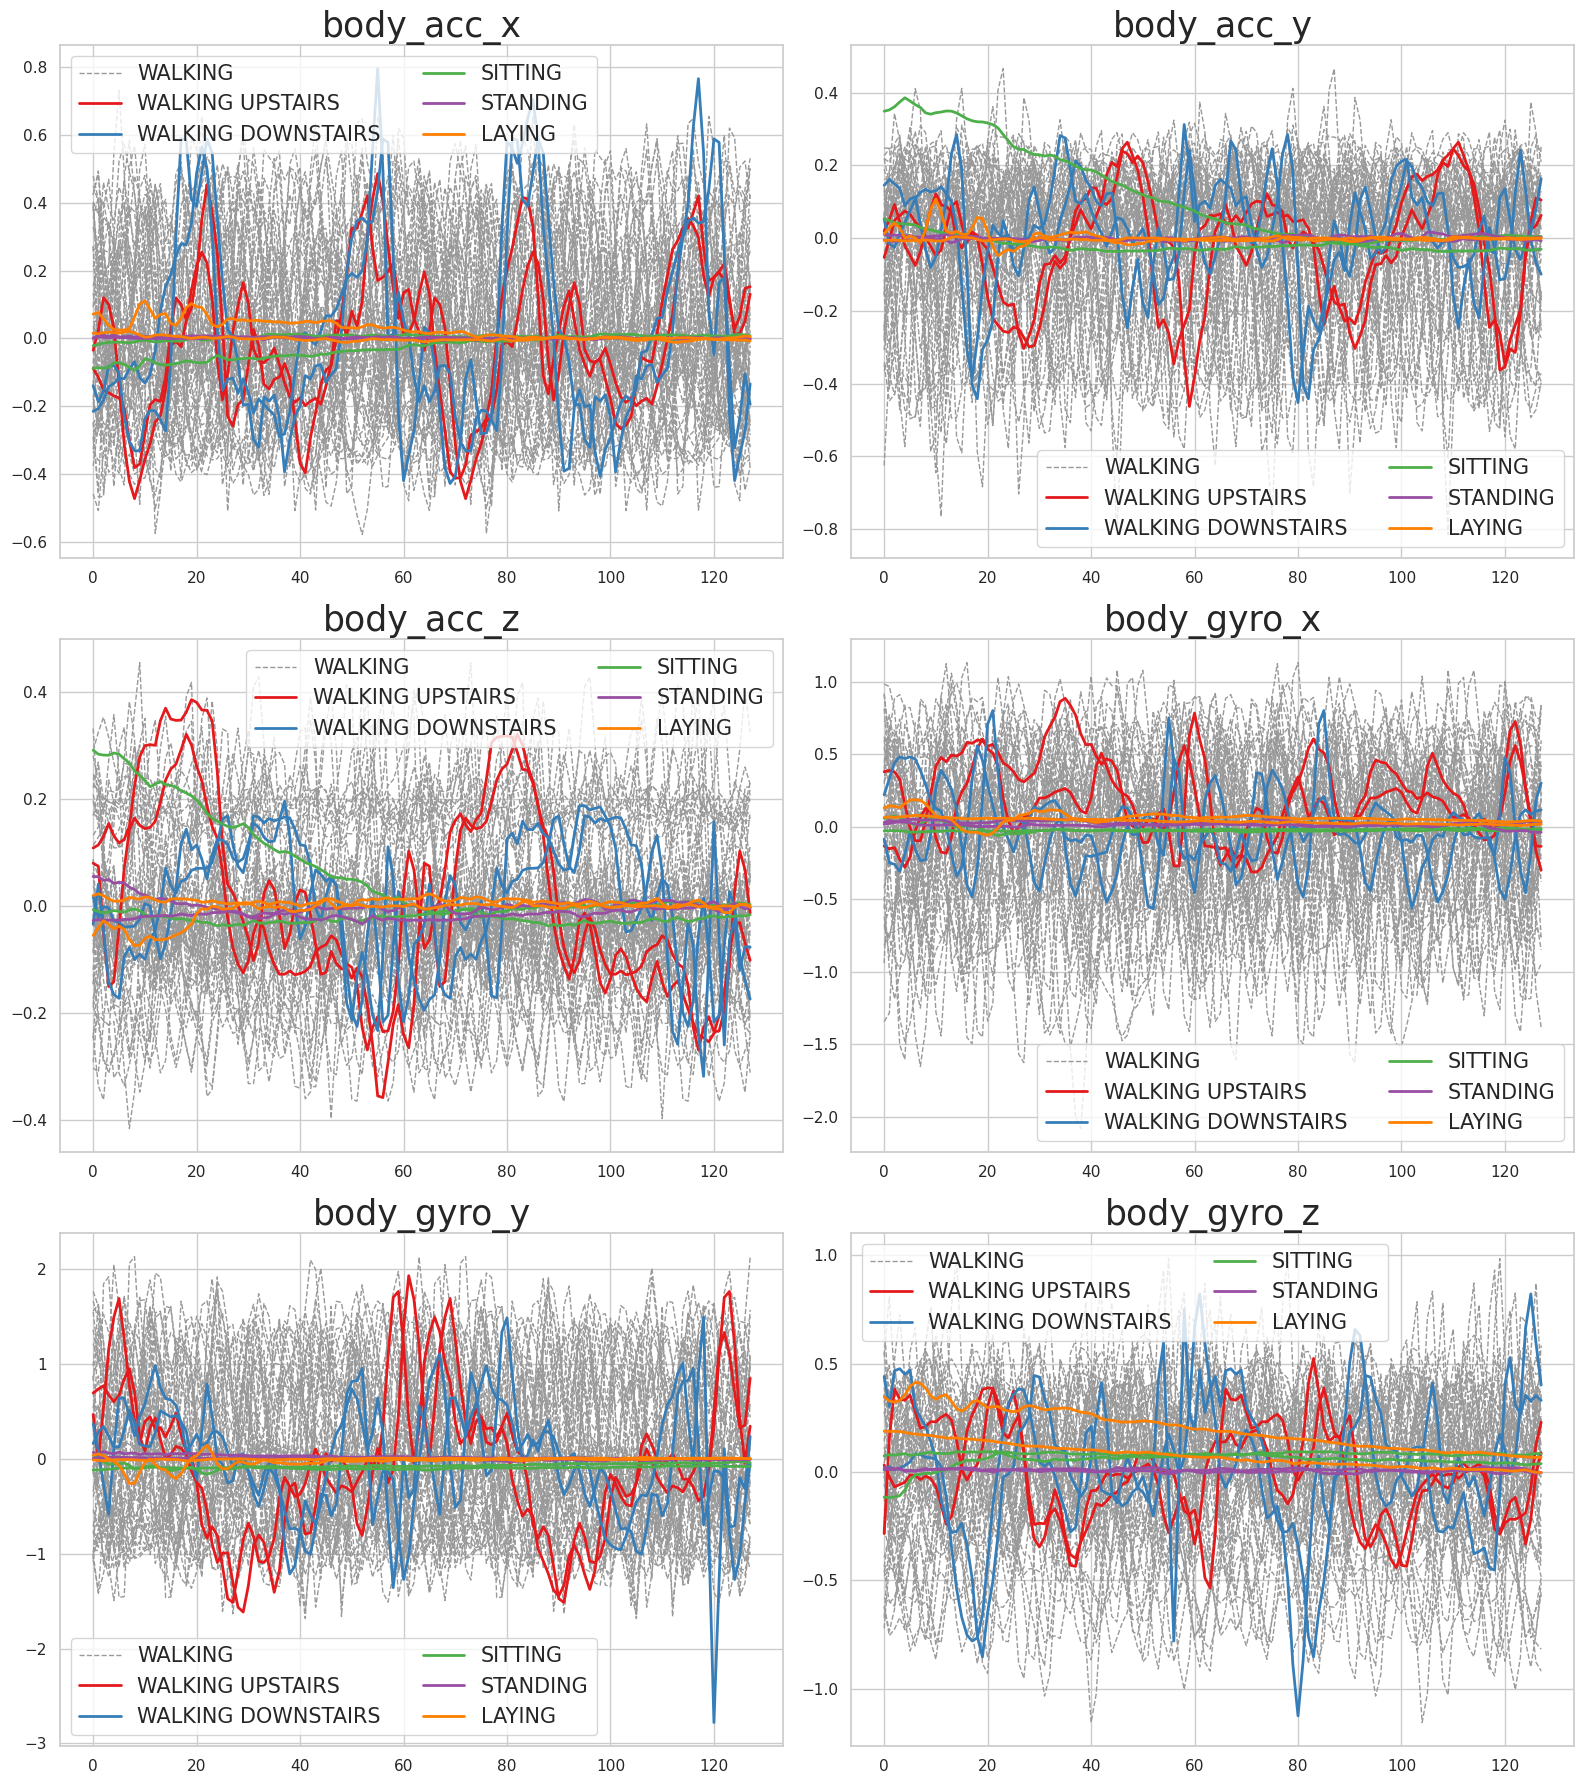

In [5]:
nb_sample_per_activity = dict([(v,50) if v=="WALKING" else (v,N_anormal) for k,v in ACTIVITY_DIC.items()])
linestyle_per_activity = dict([(v,"dashed") if v=="WALKING" else (v,"solid") for k,v in ACTIVITY_DIC.items()])
linewidth_per_activity = dict([(v,1) if v=="WALKING" else (v,2) for k,v in ACTIVITY_DIC.items()])

fig = plt.figure(figsize=(16,18))    
uil.plot_signaux(fig, X, Y_label, SIGNALS, COLOR_DIC, nb_sample_per_activity, 
             linestyle_per_activity, linewidth_per_activity, figdim1 = 3, figdim2 = 2, legend=True)


## 2.3 Principal components analysis

On extrait les features pour pouvoir appliquer des algos classiques de ML (car les données sont des séries temporelles)

### 2.3.1  For the signal : acceleration in  x

In [16]:
# on fait l'ACP sur les données de la première variable : l'accélération selon l'axe x
isignal = 0
print("ACP on signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

acp = sd.PCA()
X_acp_signal = acp.fit_transform(sp.scale(X_signal))

X_signal.shape

ACP on signal body_acc_x


(810, 128)

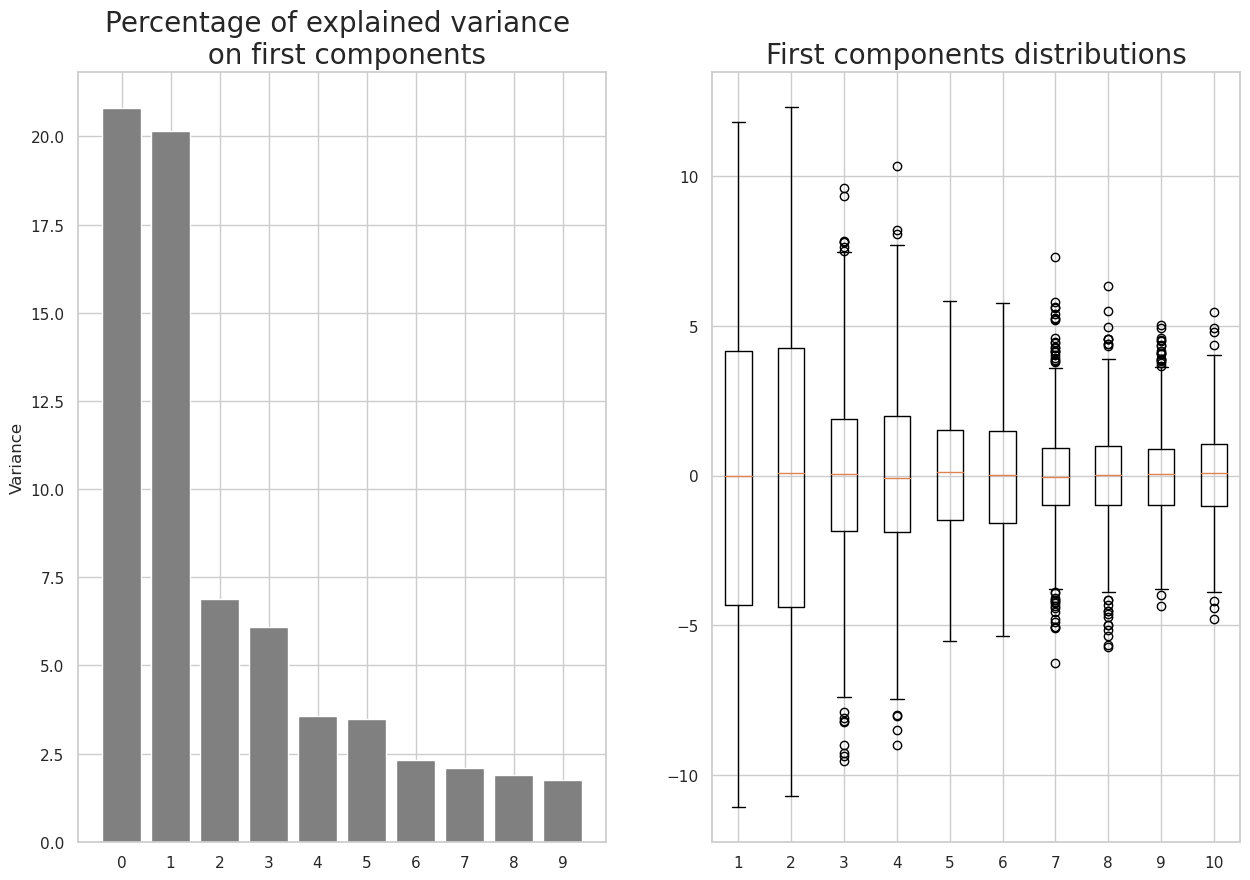

In [11]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_signal)

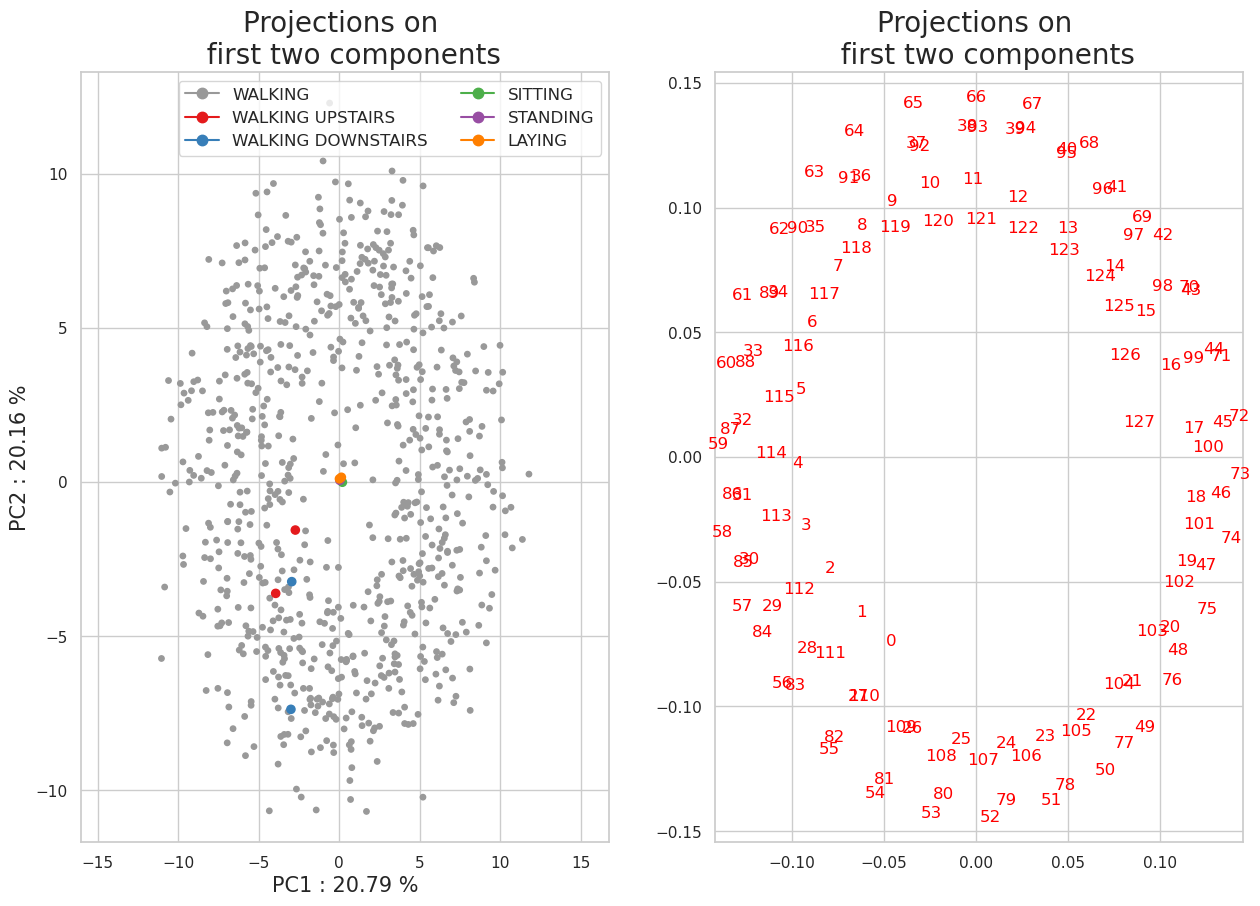

In [12]:
N = X.shape[0]
colors=[COLOR_DIC[y] for y in Y_label]
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_signal, acp, colors=colors, markersizes = markersizes, color_dic=COLOR_DIC)

**Q.** Comment these results from the perspective of anomaly detection

La PCA ne donne pas de bons résultats pour la détection d'anomalies. Dans l'idéal on voudrait obtenir deux nuages (anomalie/non amolie) distincts dans la projection sur le plan composante 1/composante 2. 

### 2.3.2  For all the signals

In [13]:
# on fait l'ACP sur toutes les variables.
X_signaux = np.vstack([x.reshape(128*6) for x in X])
acp = sd.PCA()
X_acp_signaux = acp.fit_transform(sp.scale(X_signaux))

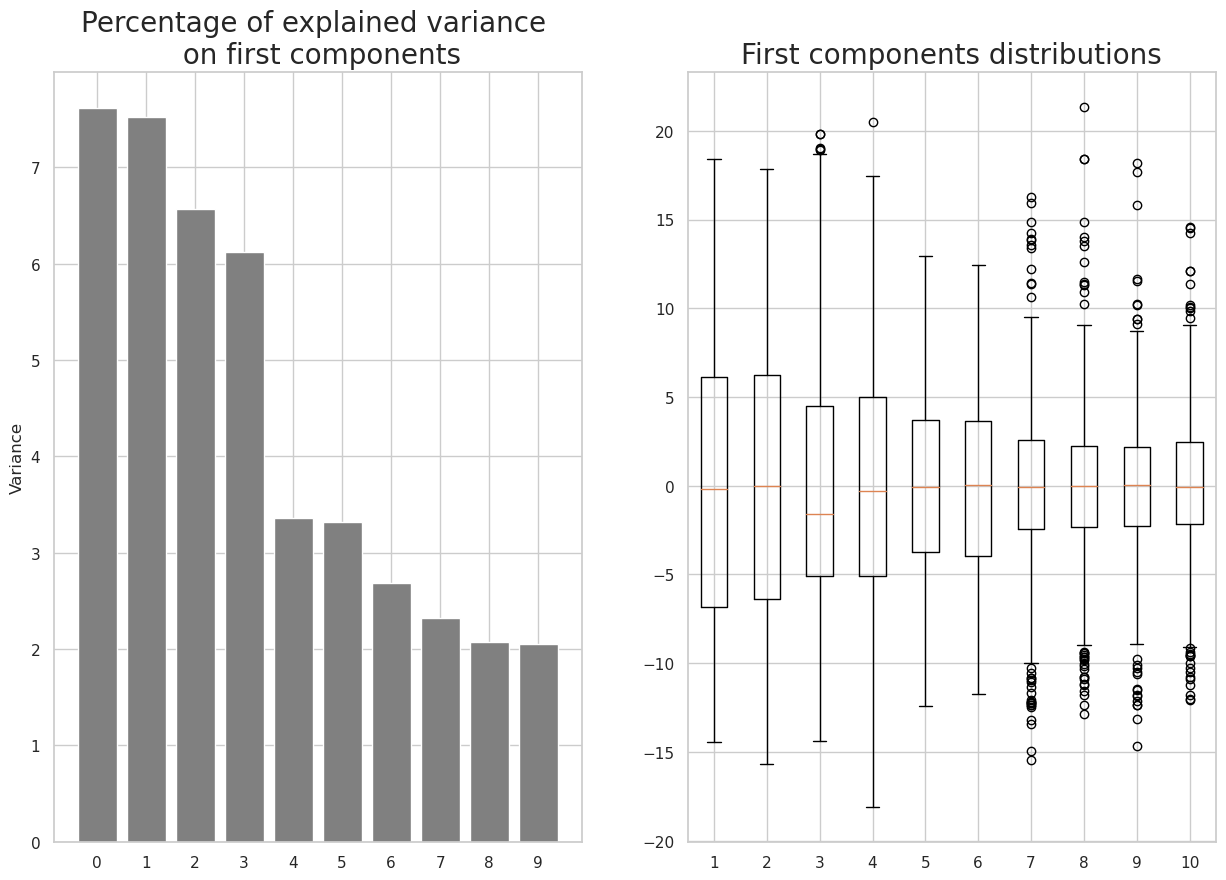

In [14]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_signaux)

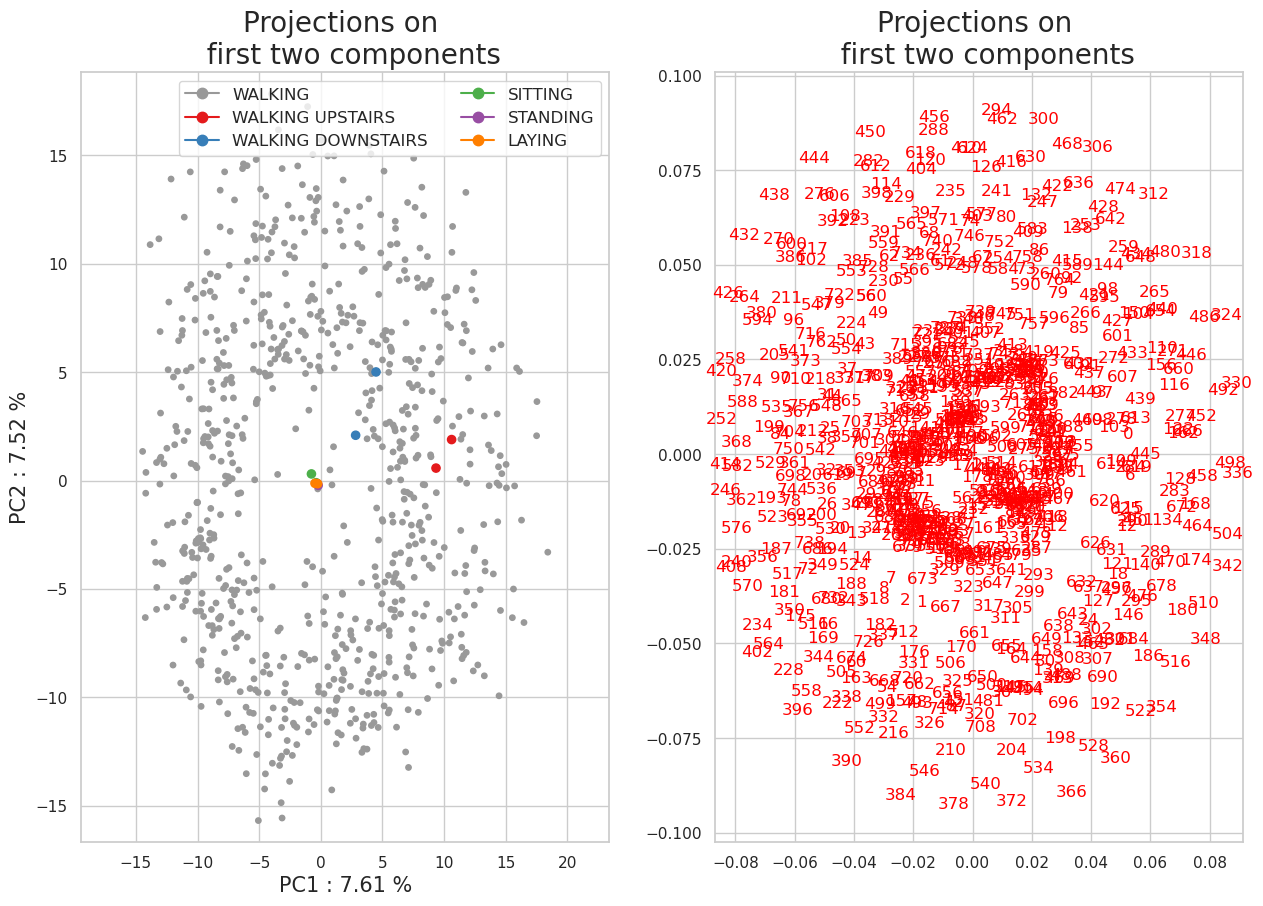

In [15]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_signaux, acp, colors, markersizes, color_dic=COLOR_DIC)

On ne peut toujours pas distinguer les outliers. 

### 2.3.3 For the *features* data

In [24]:
# On fait la PCA sur les données issues du calcul des features
acp = sd.PCA()
X_acp_metier = acp.fit_transform(sp.scale(X_metier))

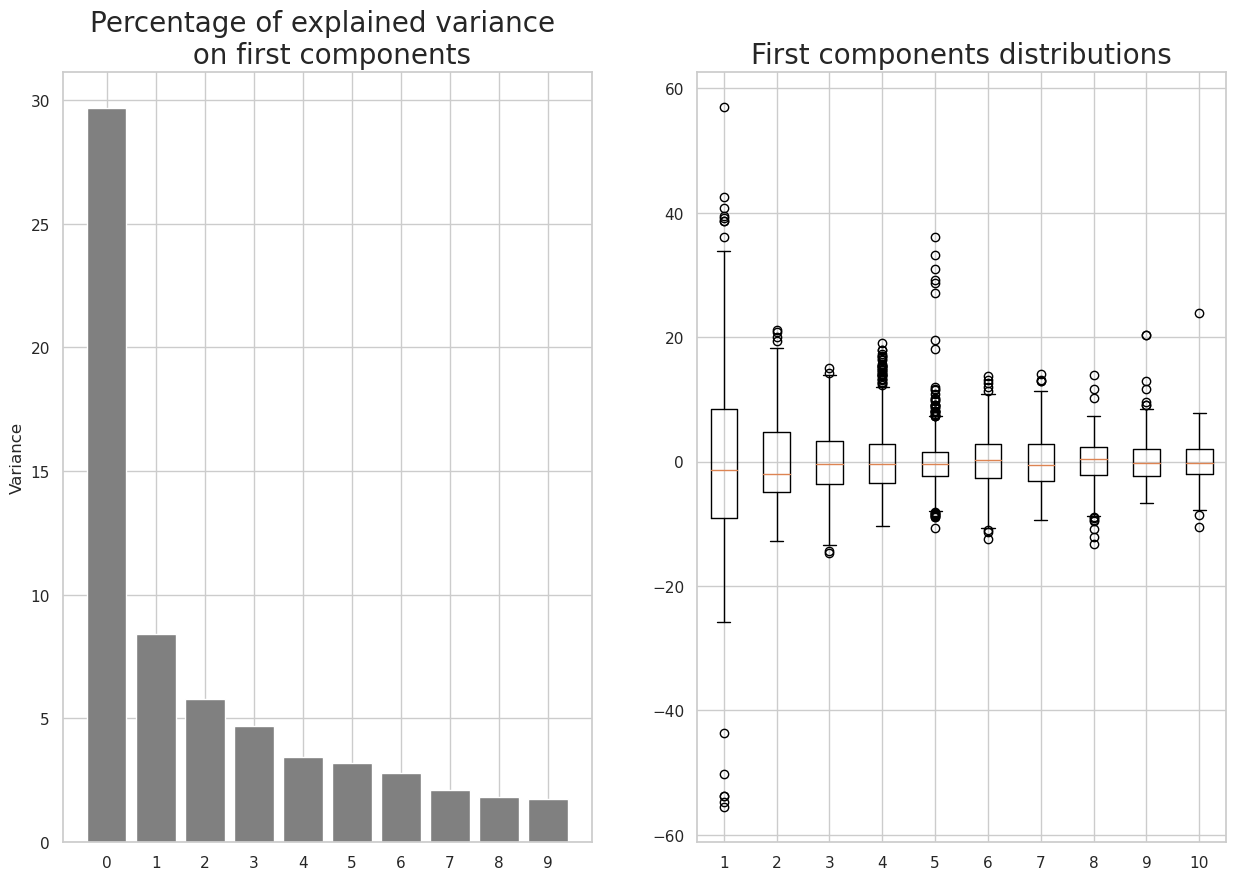

In [25]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_metier)

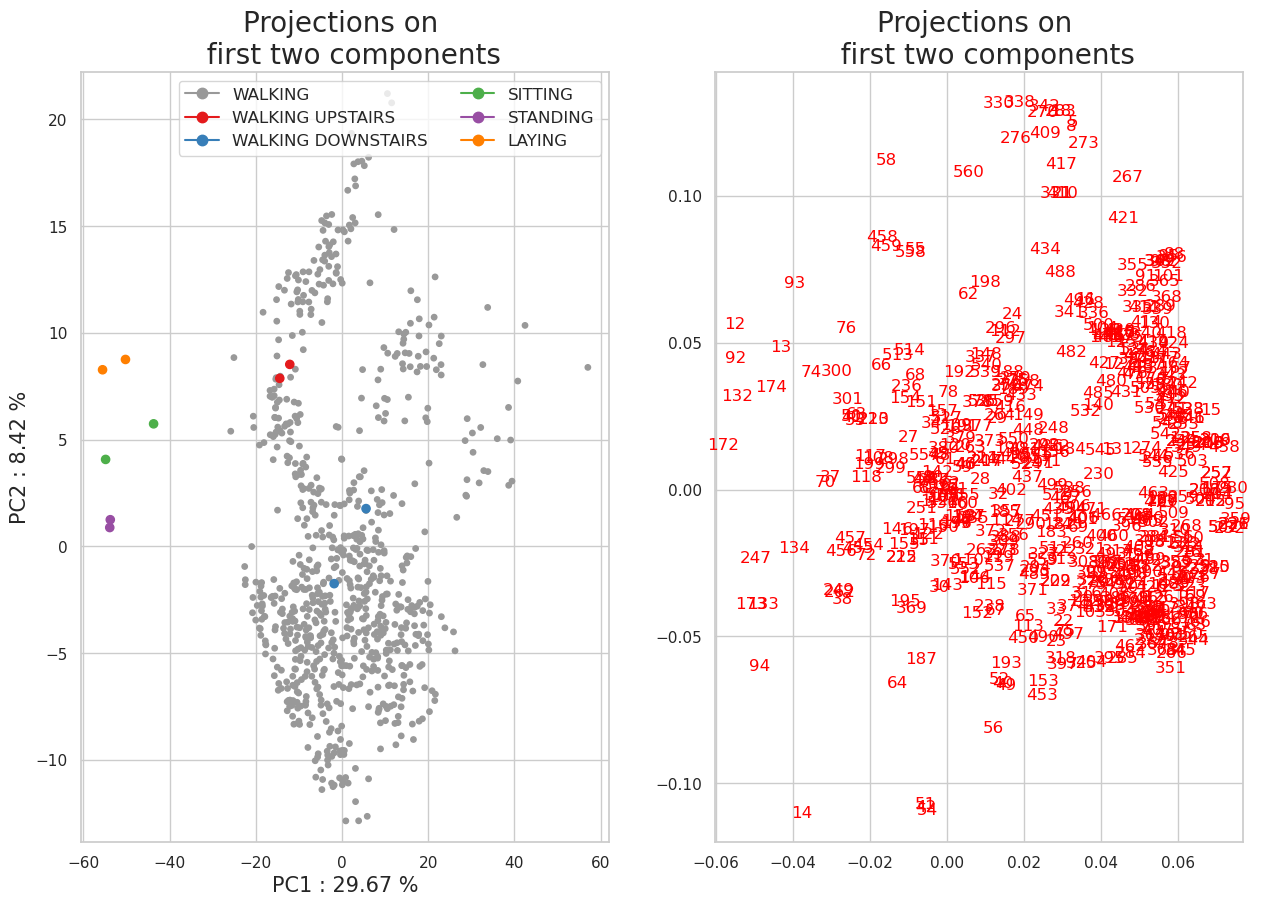

In [26]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_metier, acp, colors, markersizes, color_dic=COLOR_DIC)

** Q.** Comment these results from the perspective of anomaly detection

Après le calcul des features sur les séries temporelles, on voit que les classes anormales immobiles (layring, sitting, standing) sont isolées à l'exception des classes anormales mobiles (walking uptrairs et downstairs). 

# 3. Anomaly detection of the *features* data 

It seems quite easy to detect the anomalies from the *features* data. We apply the classical methods studied during the course: hierarchical clustering with the "single" option,  One class SVM, Local Outlier Factor and Isolation Forest. 
The different methods have not been optimized. Study the impact of the different parameters on the anomaly detection performances. 


## 3.1 Hierarchical clustering (Classification Ascendante Hiérarchique)

In [31]:
Z = sch.linkage(X_metier, 'single') #Perform hierarchical/agglomerative clustering.
C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             0        0         0      799                   2   
1             0        0         0        1                   0   
2             0        1         0        0                   0   
3             0        1         2        0                   0   
4             1        0         0        0                   0   
5             1        0         0        0                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

On commence par du hiérarchical clustering car en général, on se connaît pas à l'avance le nombre de clusters.

On voit que le hiérarcgical clustering a mis dans les clusters 1 à 5 les classes les états LAYING,SITTING et STANDING et dans la classe 0 l'état WALKING. Les classes 1 à 5 représentent les classes anormales. Les états WALKING DOWNSTAIRS et WALKING UPSTAIRS ont été mis dans la même classe que WALKING.

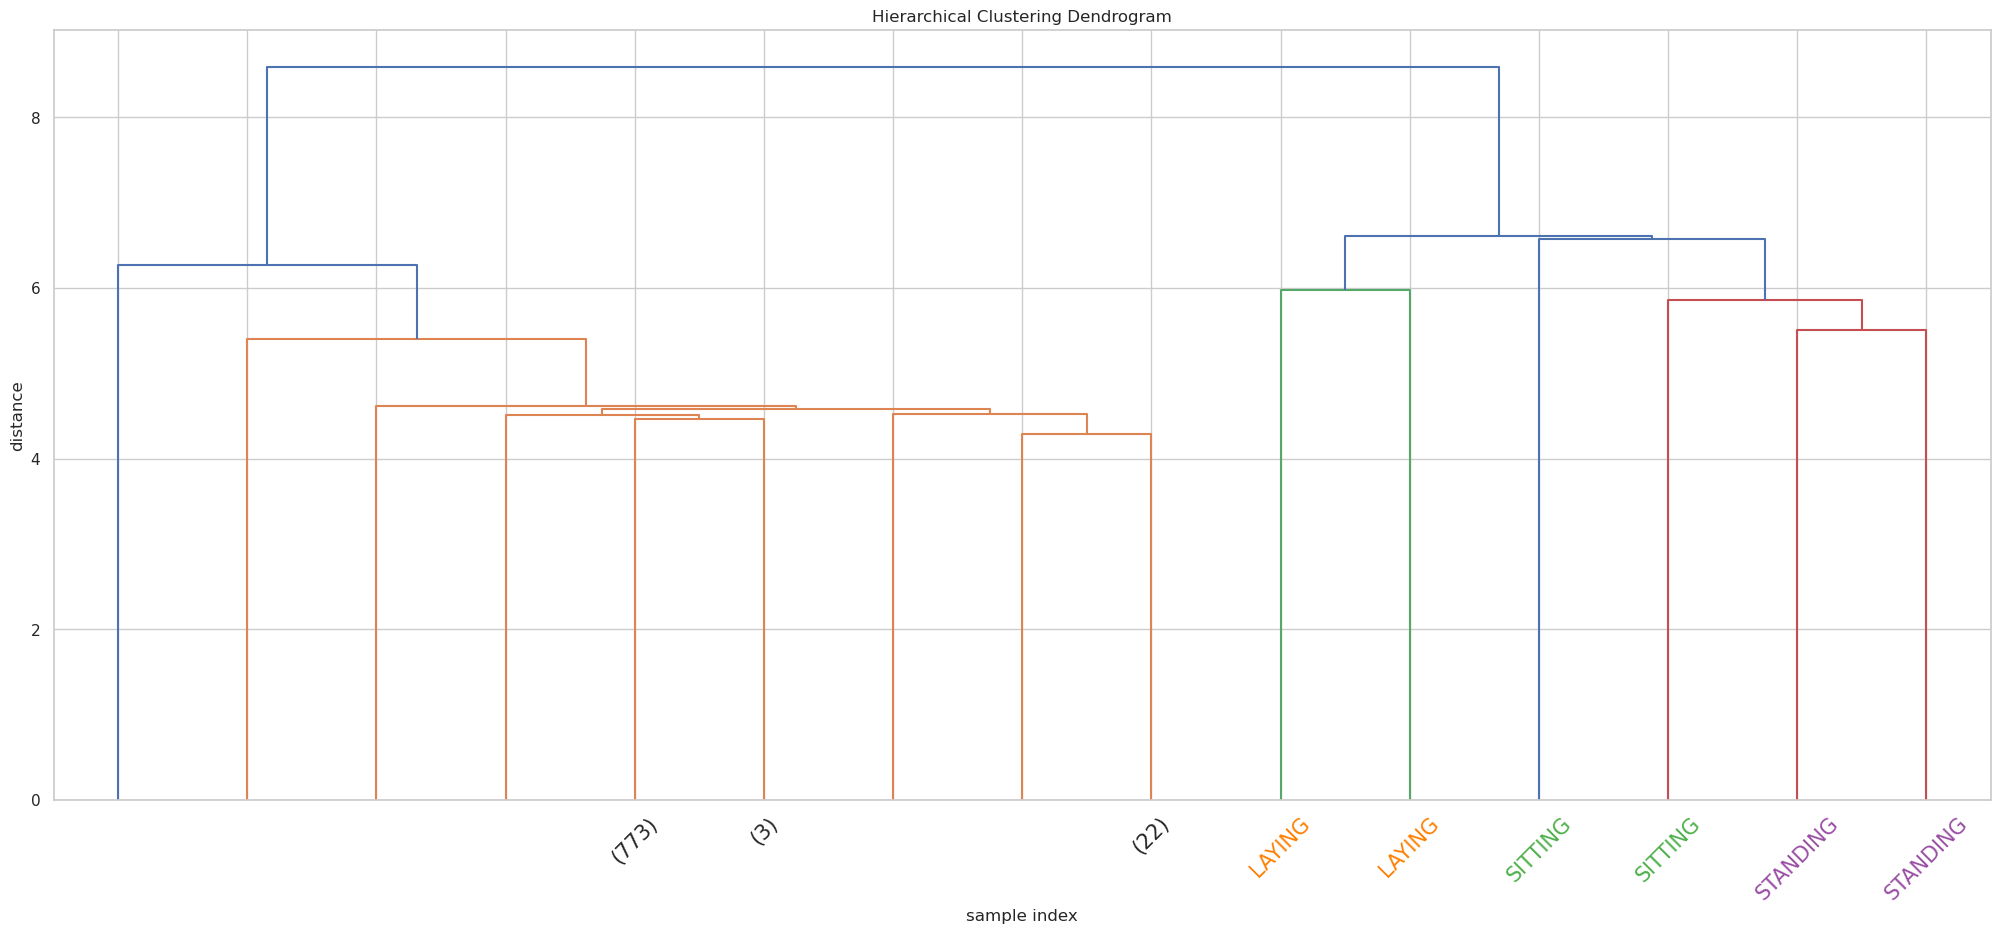

In [33]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

dès la racine du dendrogramme, on voit une séparation entre les classes immobiles et le reste du dendrogramme. 

## 3.2  One class SVM

In [34]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

OCS.fit(X_metier)
pred = OCS.predict(X_metier)

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       35                   0   
 1            0        0         0      765                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      2  
 1                      0

One class SVM: méthode où on tente de maximiser la marge qui sépare les données de l'origine. On constuit une fonction $f$ qui renvoie 1 dans le cas d'une observation normale et -1 pour une anomalie. Il faut définir sur quel support la fonction vaut 1 et sur quel support la fonction vaut -1. Pour déterminer ce support, on maximise la distance entre l'origine et la marge. 

Ici, on voit avec SVM que toutes les anomalies sont bien classifiées à l'exception de Walking Downtairs. On a aussi quelques observations normales qui ont été classés comme anomalies.

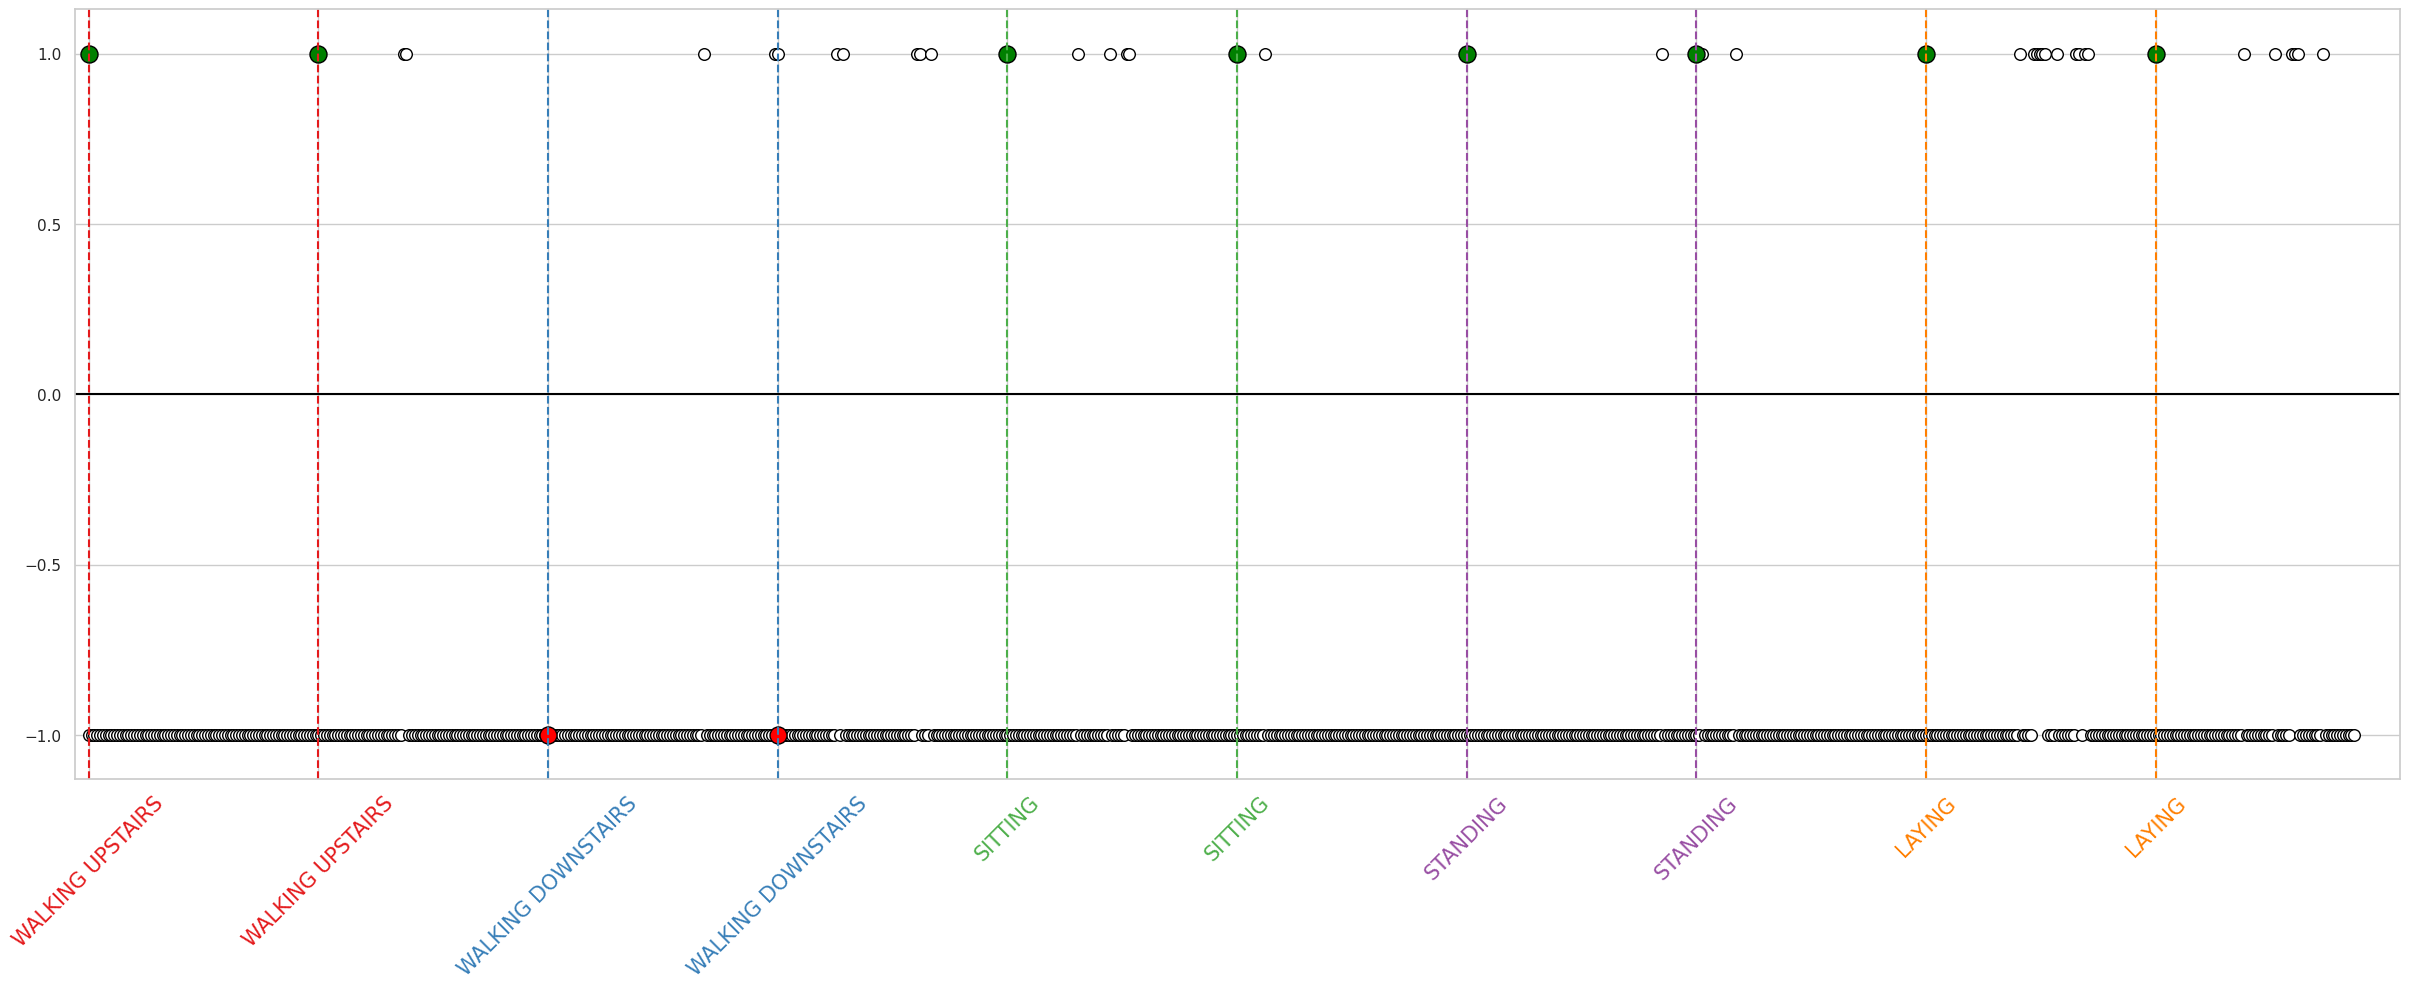

In [35]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_svm,COLOR_DIC, normal_behaviour="WALKING")

Ce graphique est juste de la visualisation. Les labels 1 et -1 ont été inversés mais ceci permet de voir les anomalies et les faux positifs. Si on ne veut pas manquer des anomalies, il vaut mieux avoir quelques faux positifs. 

## 3.3 Local Outlier Factor

regarde le ratio entre un point et ces knn et la distance entre les knn de ce point et leur propres knn. Si ce ratio est grand, le point est un outlier .

In [36]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_metier)

CT_metier_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_metier_lof.pred, CT_metier_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       31                   2   
 1            0        0         0      769                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      2  
 1                      0

Cette méthode fonctionne mieux que précedemment car toutes les anomalies ont été classées comme anormales et nous avons moins de faux positifs.

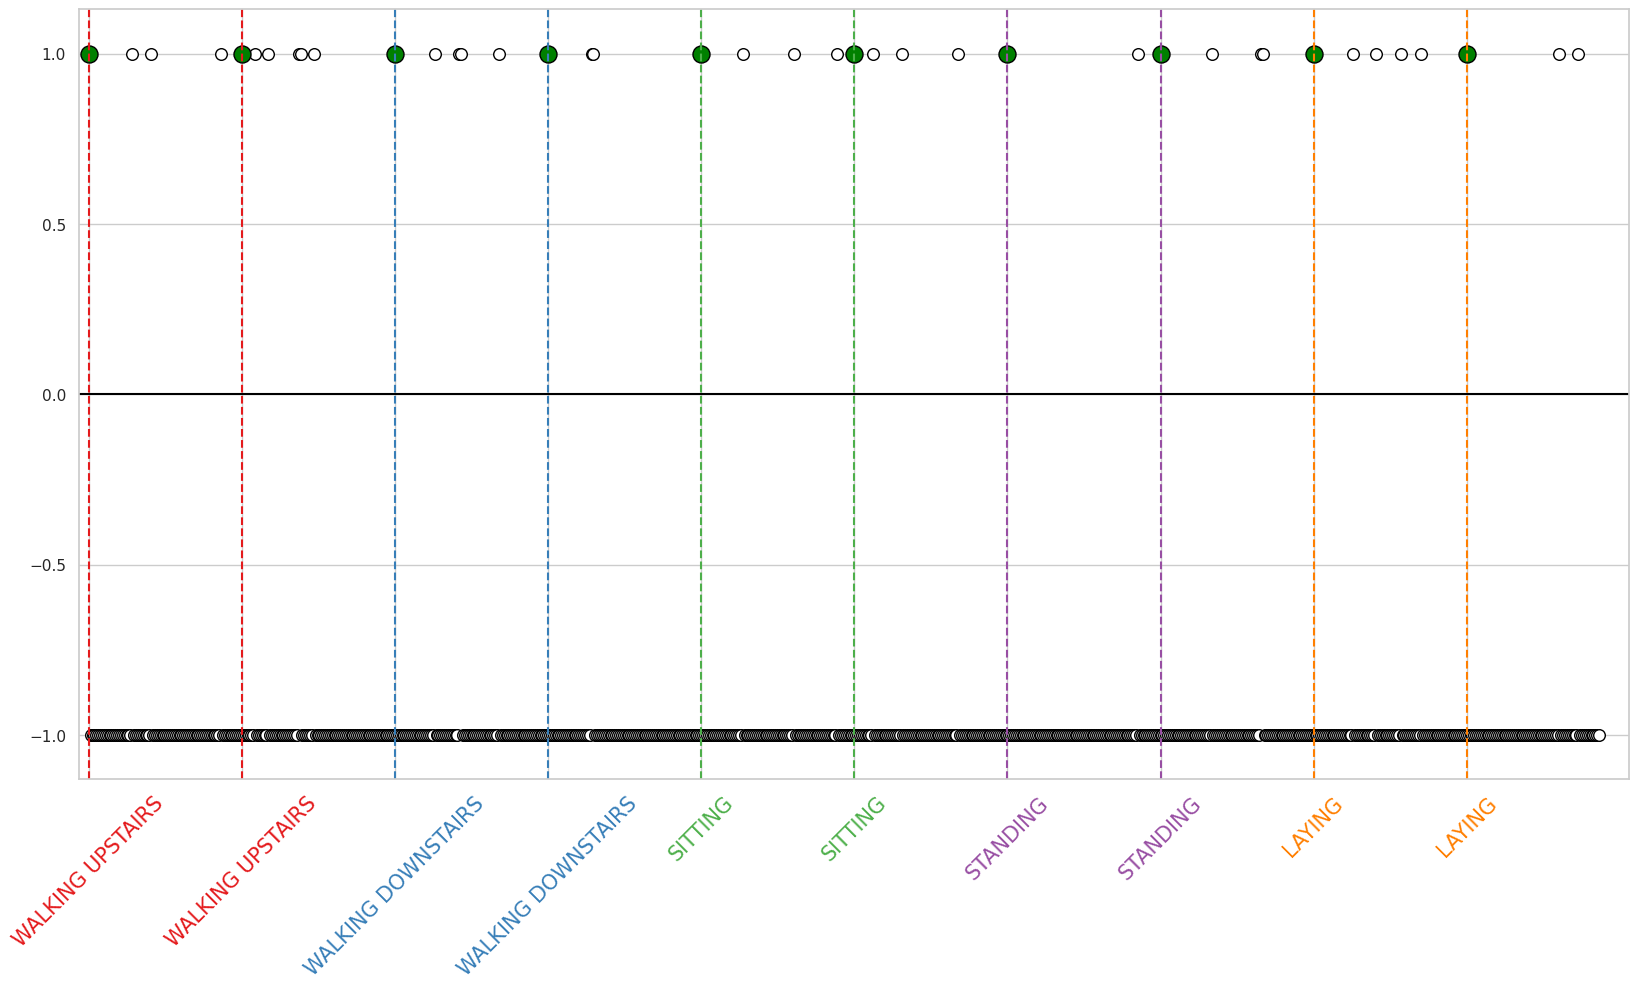

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_metier_lof, COLOR_DIC, normal_behaviour="WALKING")


Points blancs = faux positifs.

## 3.4 Isolation Forest

In [38]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)

clf.fit(X_metier)
y_pred = clf.predict(X_metier)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       35                   0   
 1            0        0         0      765                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

Cette méthode donne les moins bons résultats car elle ne détecte pas les anomalies WALKING DOWNSTAIRS et WALKING UPSTAIRS.

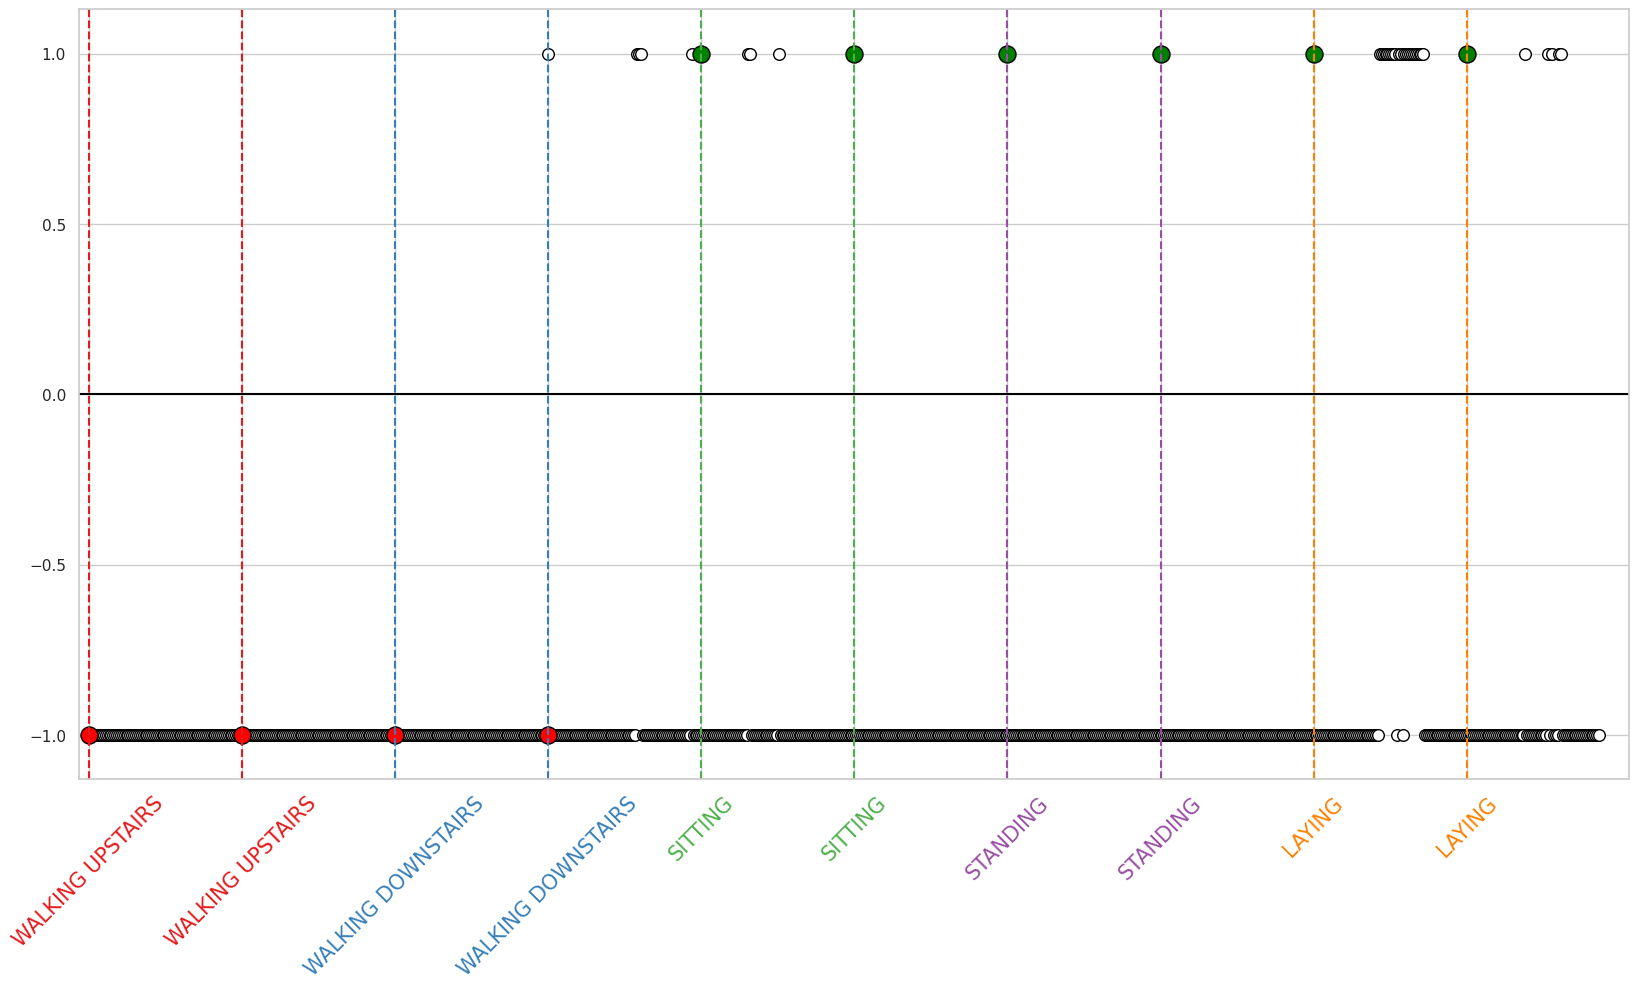

In [39]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_IF, COLOR_DIC, normal_behaviour="WALKING")

**Q. ** What is your  conclusion on the *features* data ? 

Conclusion: faire de la détection d'anomalie sur les features data fonctionne mieux que sur les données brutes. Ici, c'est `Local Outlier Factor` qui donne les meilleurs résultats (détecte toutes les anomalies avec quelques faux positifs). 

The objective of the next sections is to try to detect the  anomalies from the raw data or from simple transformations of the raw data. 


# 4. Anomaly detection on the raw data

## 4.1 Hierarchical clustering

We first use a single signal : acceleration in x


In [40]:
Z = sch.linkage(X_signal,'single')

C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             2        2         2      793                   2   
1             0        0         0        3                   0   
2             0        0         0        1                   0   
3             0        0         0        1                   0   
4             0        0         0        1                   0   
5             0        0         0        1                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

Sur les données brutes, le hiérarchical clustering n'a détecté aucune anomalie et ne génère que des faux positifs. 

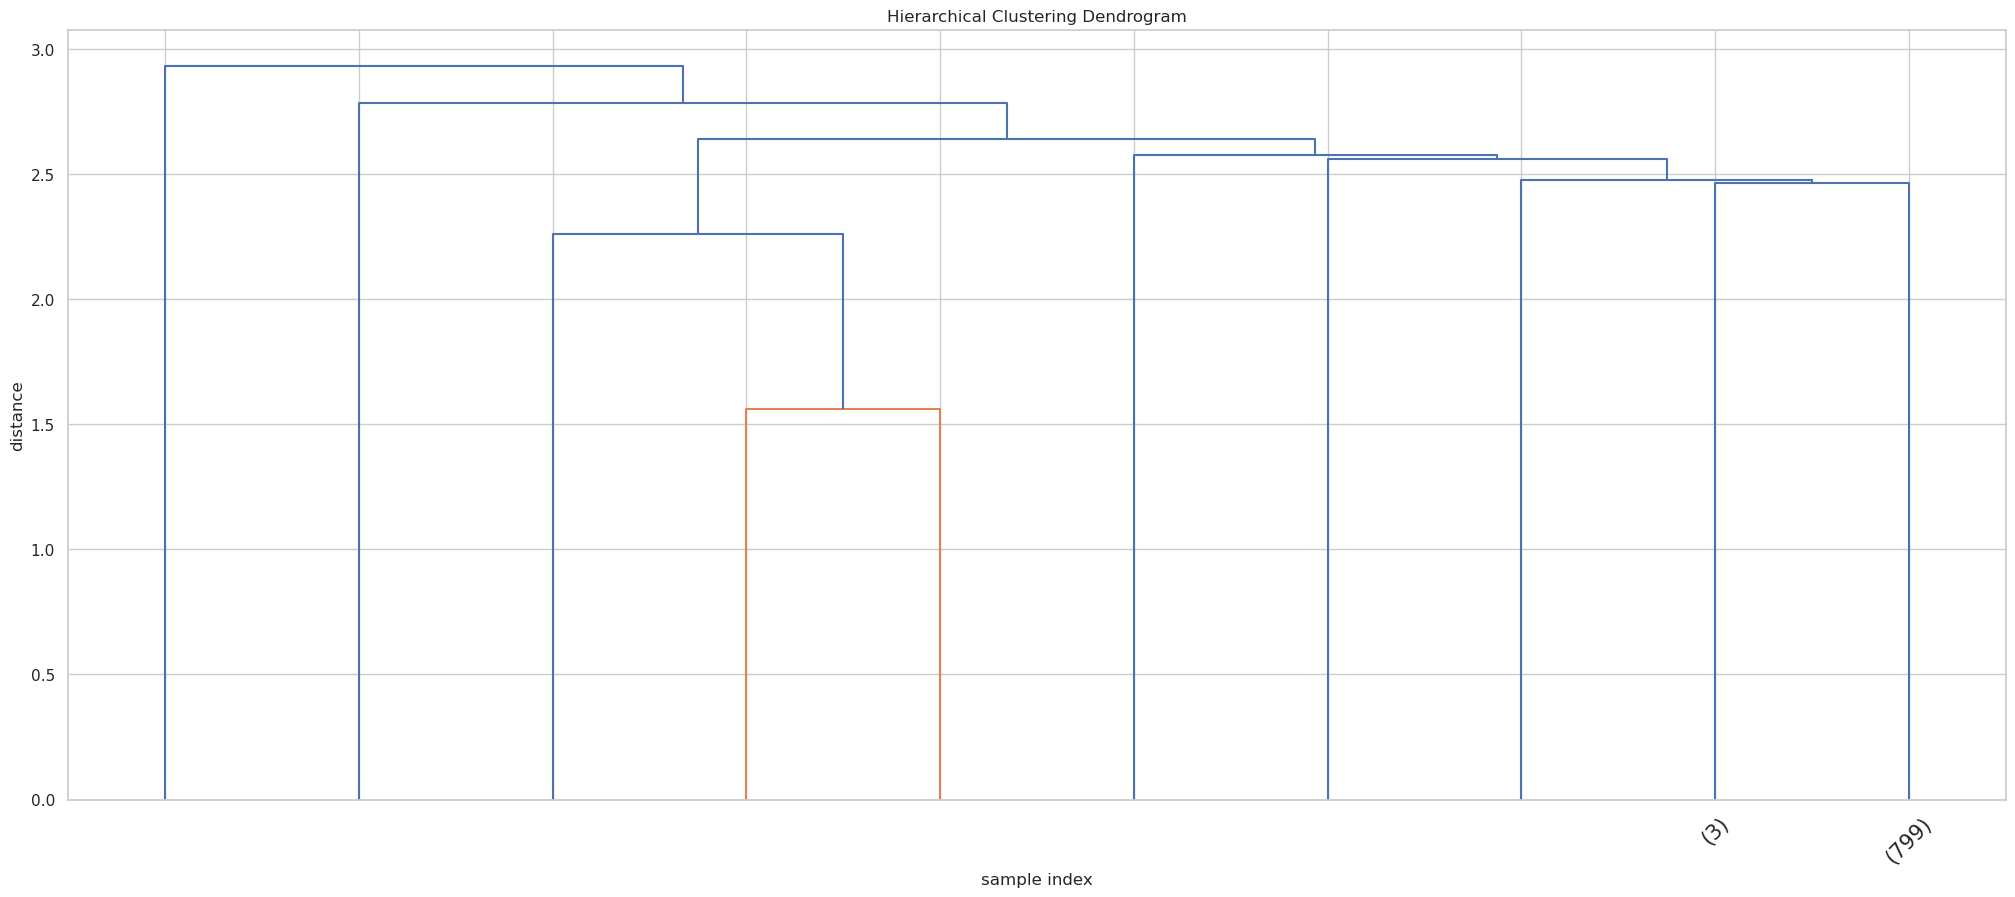

In [41]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

**Q.** How many anomalies have been detected? Do you get better results by taking all the signals?

En comparaison à précedemment, on n'observe pas de démarcation sur le dendrogramme.

## 4.2 One class SVM

### 4.2.1 On the two first PCA components

In [45]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.01)

nb_composante = 2

OCS.fit(X_acp_signal[:,:nb_composante])
pred = OCS.predict(X_acp_signal[:,:nb_composante])

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            1        2         2        7                   0   
 1            1        0         0      793                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Comment on the results. Do you get better results by increasing the number of components?

Avec la SVM sur les deux première composantes de la PCA, nous obtenons de meilleurs résultats qu'avec le hiérarchical clustering. Cependant, WALKING DOWNSTAIRS et WALKING UPSTAIRS ne sont toujours pas détectés. LAYING n'est détecté qu'une fois sur deux.

En augmentant le nombre de composantes, on obtient de moins bons résultats. 

Text(0.5, 1.0, 'Novelty Detection : nu=0.0')

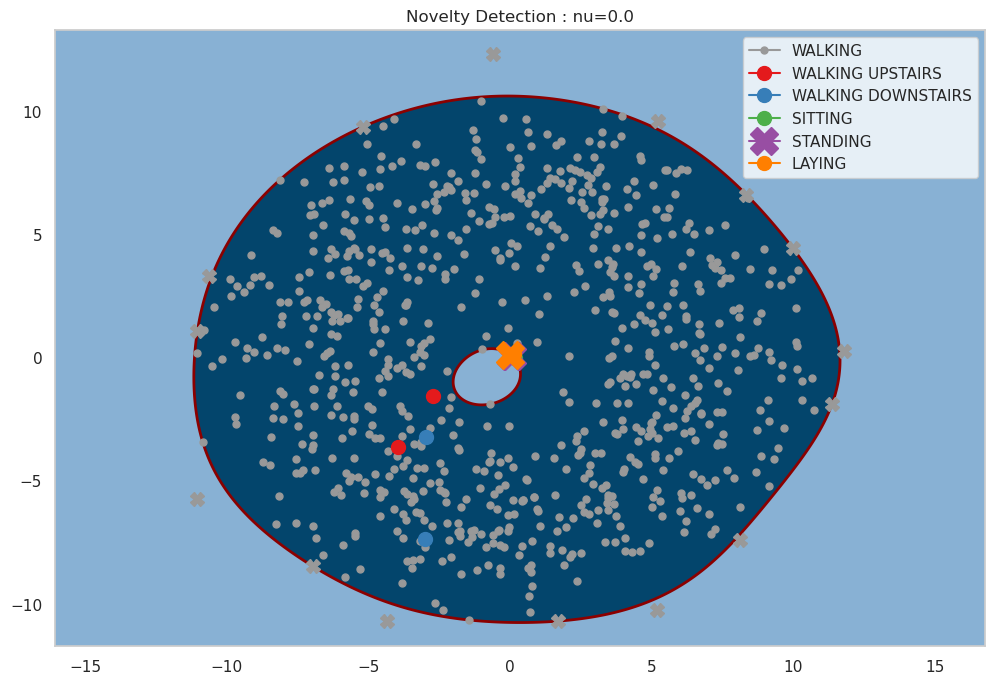

In [46]:
X_acp = X_acp_signal
nu = 0.02

# fit the model
clf = ssvm.OneClassSVM(kernel="rbf",nu=nu)
clf.fit(X_acp[:,:nb_composante])
y_pred_train = clf.predict(X_acp[:,:nb_composante])


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

markersizes = [10 if y==1 else 20 for y in Y]
labels = [""] * N 
for il, l in [(np.where(Y_label==y)[0][0],y) for y in set(Y_label)]:
    labels[il] = l

uil.plot_decision_function(fig, ax, clf, X_acp, y_pred_train, colors=colors, labels = labels, markersizes=markersizes)
ax.set_title("Novelty Detection : nu=%.1f" %nu)


Sur le schéma ci-dessus: les croix sont les outliers. Ils se situent sur les zones bleu clair ie sur les zones où la fonction calculée par SVM vaut -1. 

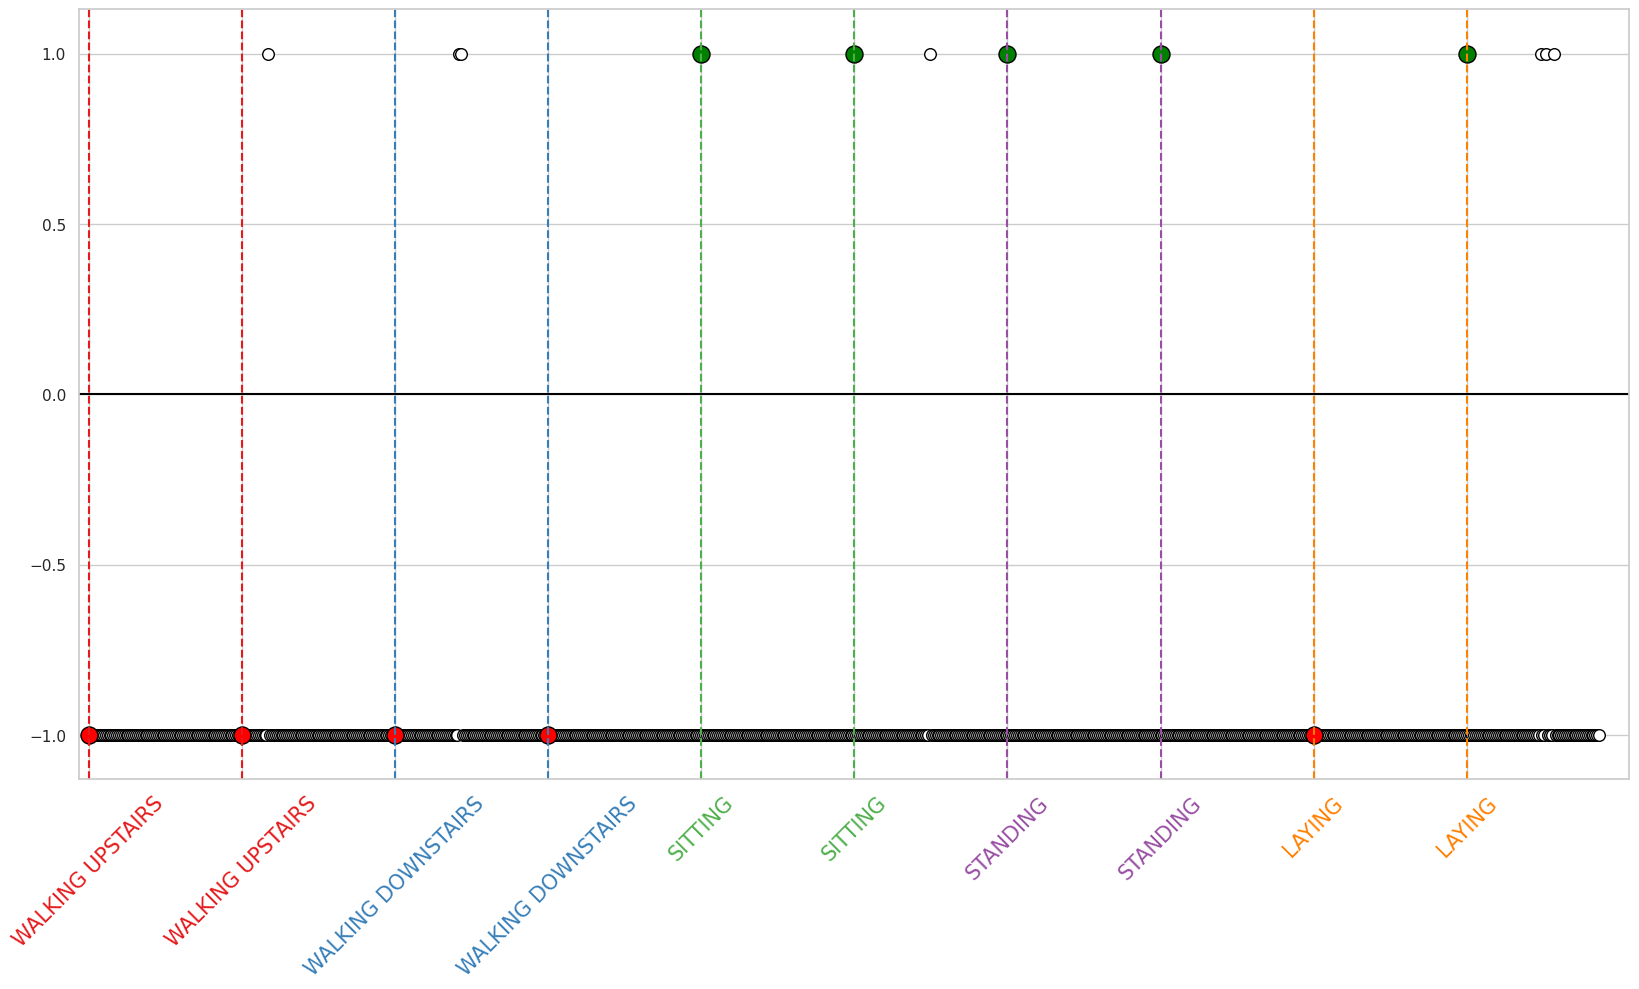

In [48]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_svm, COLOR_DIC, normal_behaviour="WALKING")


### 4.2.2 On the acceleration in x :

In [49]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

OCS.fit(X_signal)
pred = OCS.predict(X_signal)

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       51                   1   
 1            2        2         2      749                   1   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Comment on the results. Does applying the method on all the signals improve the results?

On applique OneClass SVM sur une seule variable (accélération x). La discrimination n'est toujours pas meilleure, les classes immobiles et walking upstairs sont classifiées comme normales. 

## 4.3 Local Outlier Factor

### 4.3.1 On the acceleration in  x : 

In [50]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_signal)

CT_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof.pred, CT_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

Les résultats de sont outjours pas satisfaisants. L'accéléation selon x n'est peut-être pas la variable qui permet de détecter les anomalies.

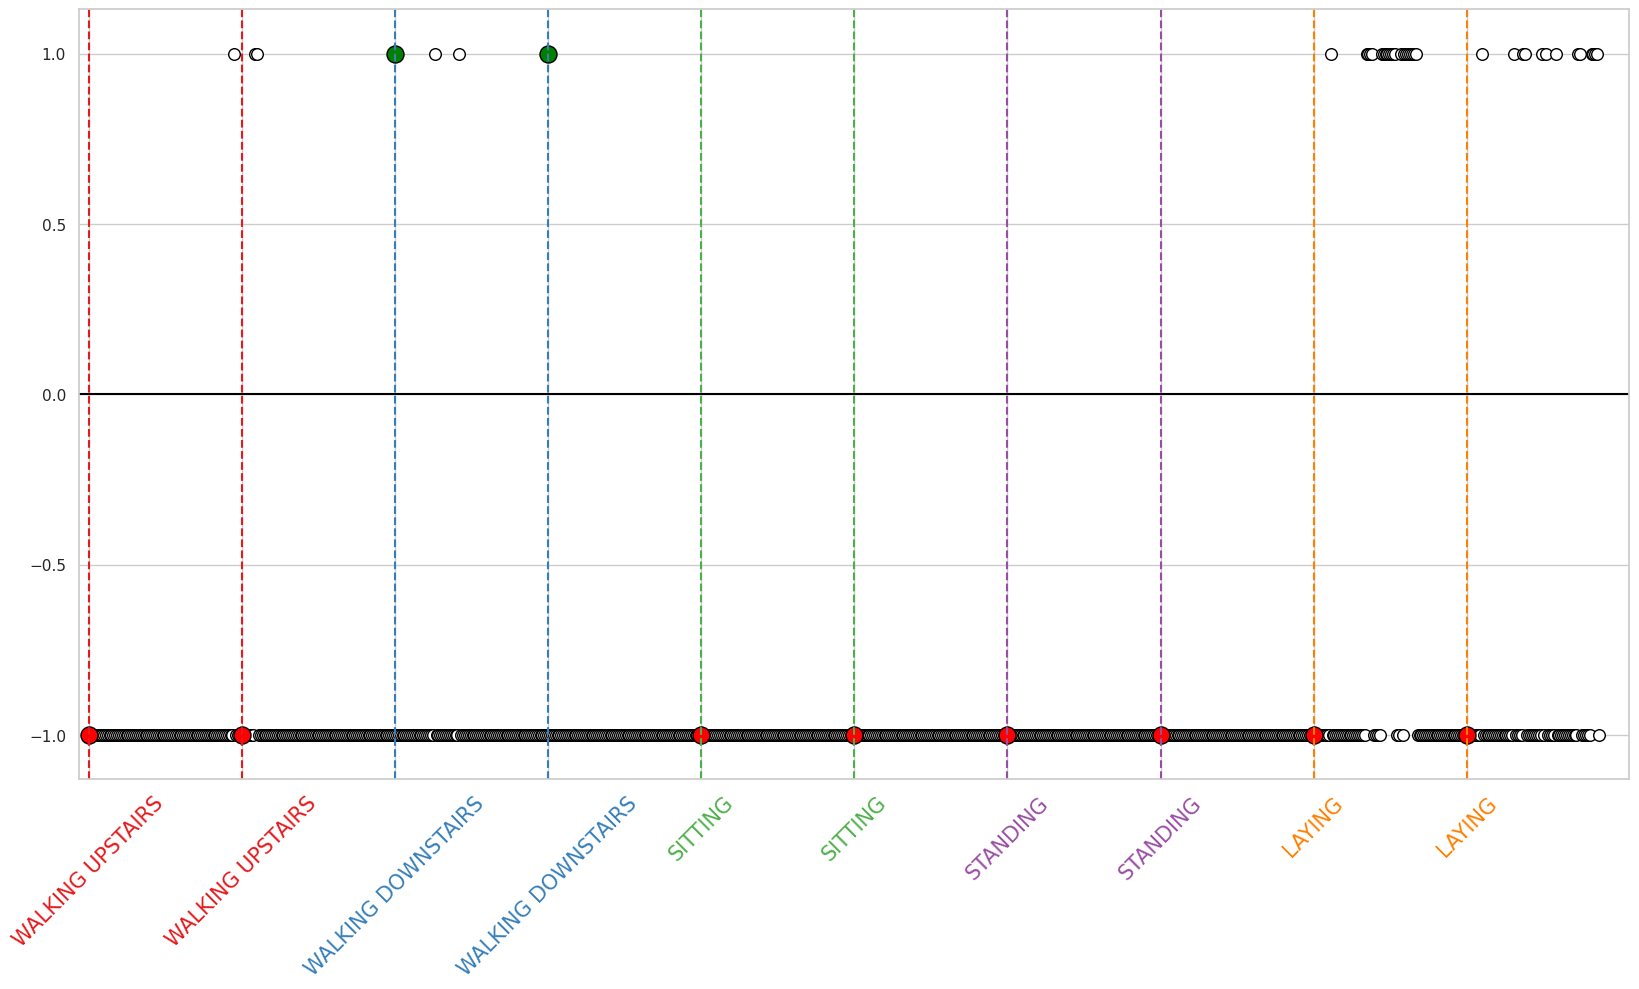

In [51]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_lof, COLOR_DIC, normal_behaviour="WALKING")

In [58]:
# Local Outlier Factor sur tous les signaux
contamination=0.05 #taux d'anomalie présentes dans le jeu de données (supposition)
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_signaux)

CT_tous_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_tous_lof.pred, CT_tous_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       41                   0   
 1            2        2         2      759                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Comment on the results. Do you get better performances on all the signals? By changing the parameters?

Nous n'obtenons pas de meilleurs résultats avec tous les signaux (l'ensemble des données brutes), même en faisant varier les paramètres.

### 4.3.2 On the PCA components : 

In [59]:
X_acp = X_acp_signal
n_neighbors = 15

# fit the model
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric = metric)
y_pred = clf.fit_predict(X_acp[:,:2])

CT_ACP_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof.pred, CT_ACP_lof.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

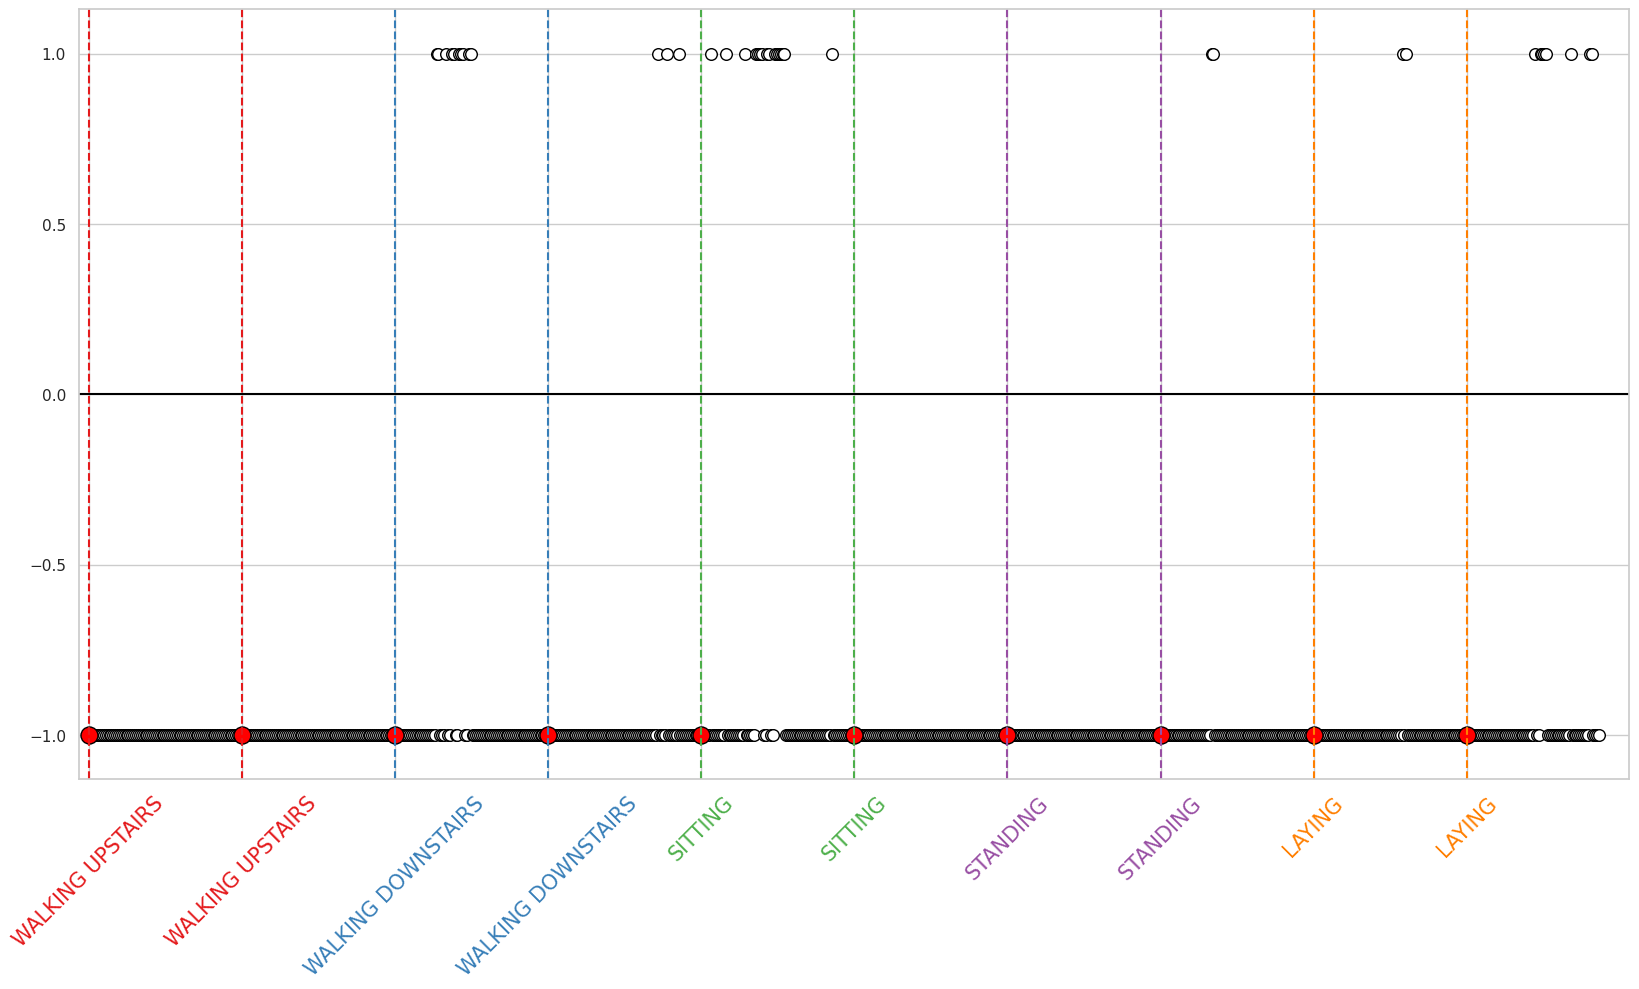

In [60]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_ACP_lof, COLOR_DIC, normal_behaviour="WALKING")

## Souci : les anomalies détectées ne s'affichent pas !


## 4.4 Isolation Forest

### 4.4.1 On the acceleration in  x :

In [61]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)


clf.fit(X_signal)
y_pred = clf.predict(X_signal)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       41                   0   
 1            2        2         2      759                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

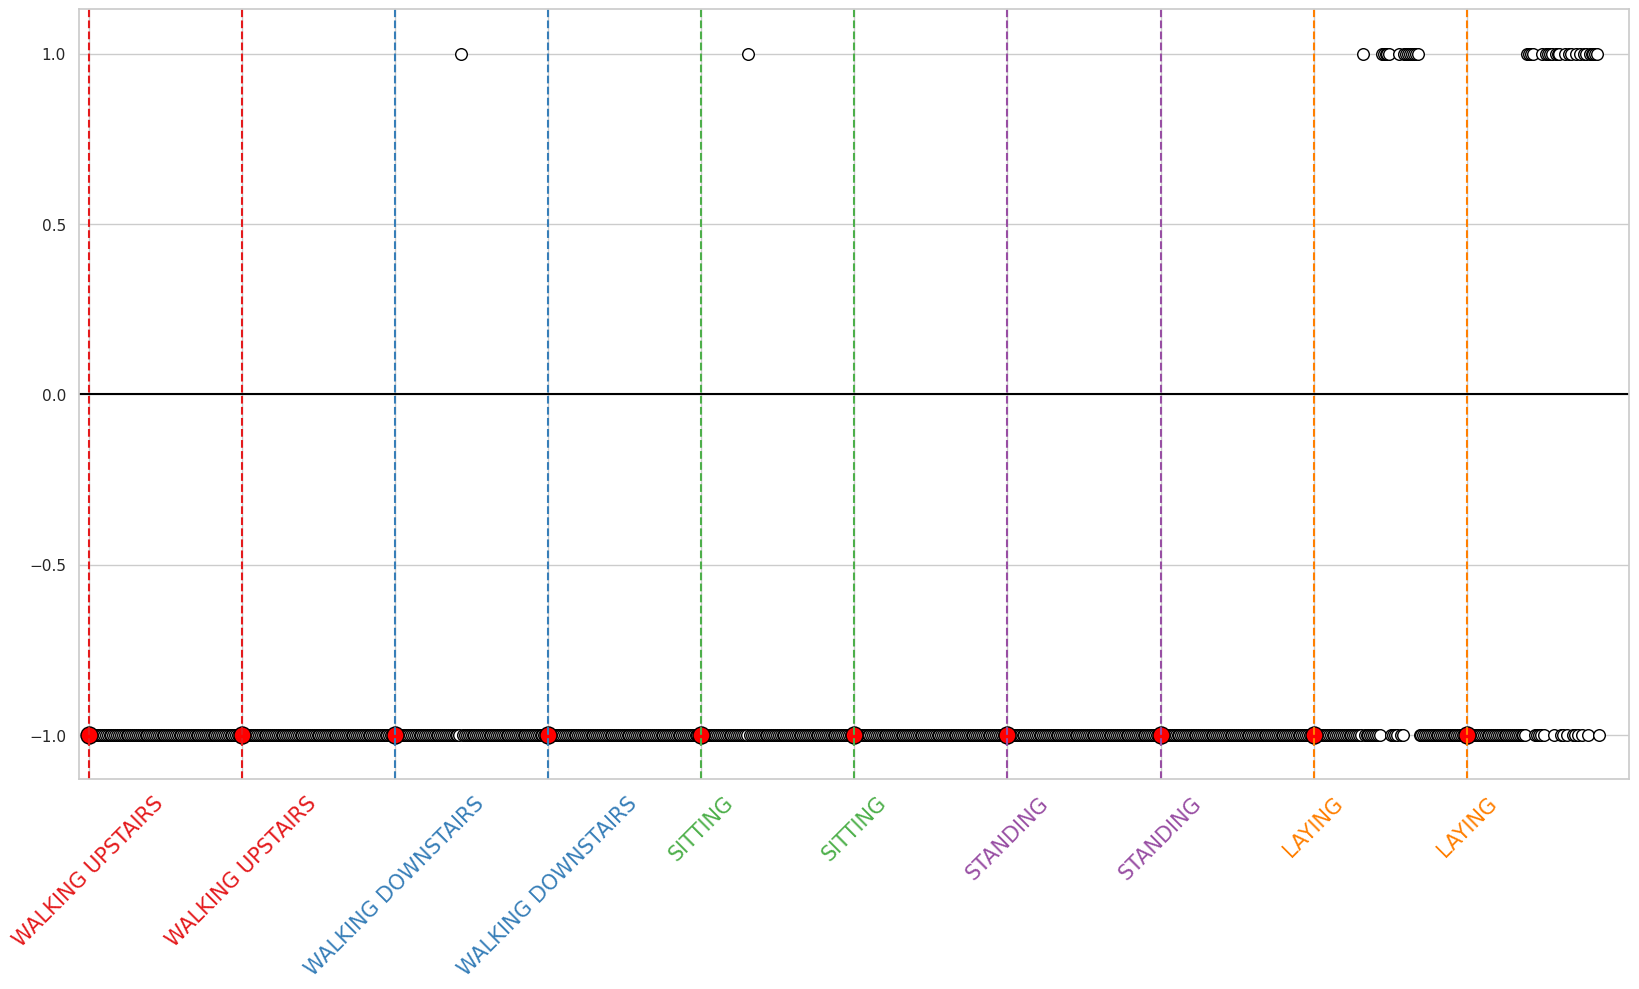

In [62]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_IF, COLOR_DIC, normal_behaviour="WALKING")


### 4.4.2 On the PCA components

In [66]:
X_acp = X_acp_signal

contamination=0.05
clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)

nb_composantes = 5

clf.fit(X_acp[:,:nb_composantes])
y_pred = clf.predict(X_acp[:,:nb_composantes])

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))



Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Do you get better results by increasing the number of PCA components ? 

On obtient légèrement de meilleurs résultats en augmentant le nombre de composantes. Avec 5 composantes, on discrimine walking downtairs.

**In conclusion**, the anomaly detection methods applied directly to the signals do not work well. We will see in the next section if the projection onto a wavelet basis allows to obtain better results. 

# 5. Anomaly detection based  on wavelet decompositions of the signals


## 5.1 Wavelet decomposition

We work with the acceleration in x.  

In [67]:
import pywt
from pywt import wavedec

from statsmodels.robust import mad

In [68]:
isignal = 0
print(" signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

 signal body_acc_x


In [69]:
wf = "haar"

Coeff = []
TCoeff = []
for x in X_signal :
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=7)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(128))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(810, 128) (810, 128)
103680 26739


On calcule la transformée en ondelette de haar et on ne garde que les premiers coefficients (seuillage dur en ondelettes). et pas omelette :) 

We only keep the coefficients from levels 1 to 4, the others are considered as noise and are canceled.

In [71]:
#Coefficients dfrom levels  1 to 4 : 
CoeffA4=Coeff[:,:16]

## 5.2 PCA of the wavelet coefficients

In [72]:
acp = sd.PCA()
X_acp_ond = acp.fit_transform(sp.scale(Coeff))

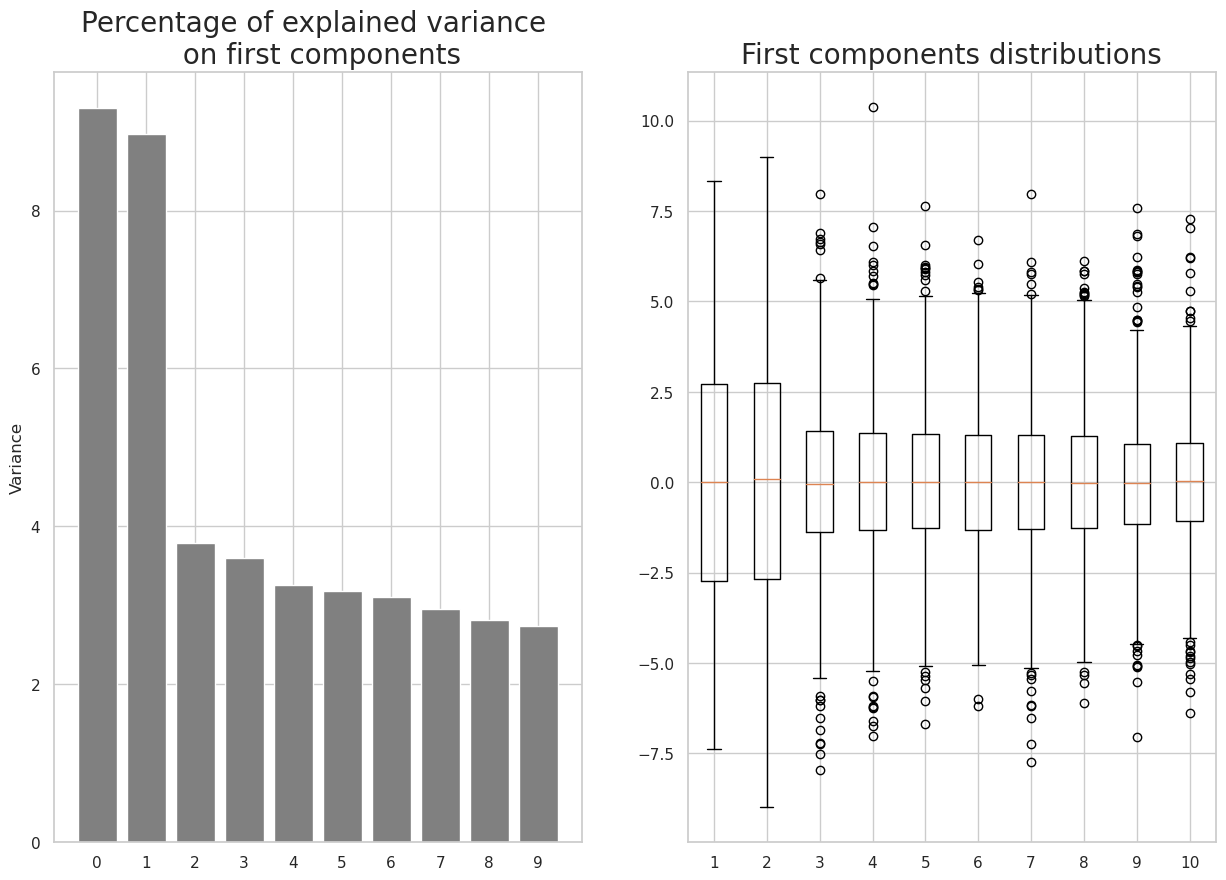

In [73]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_ond)

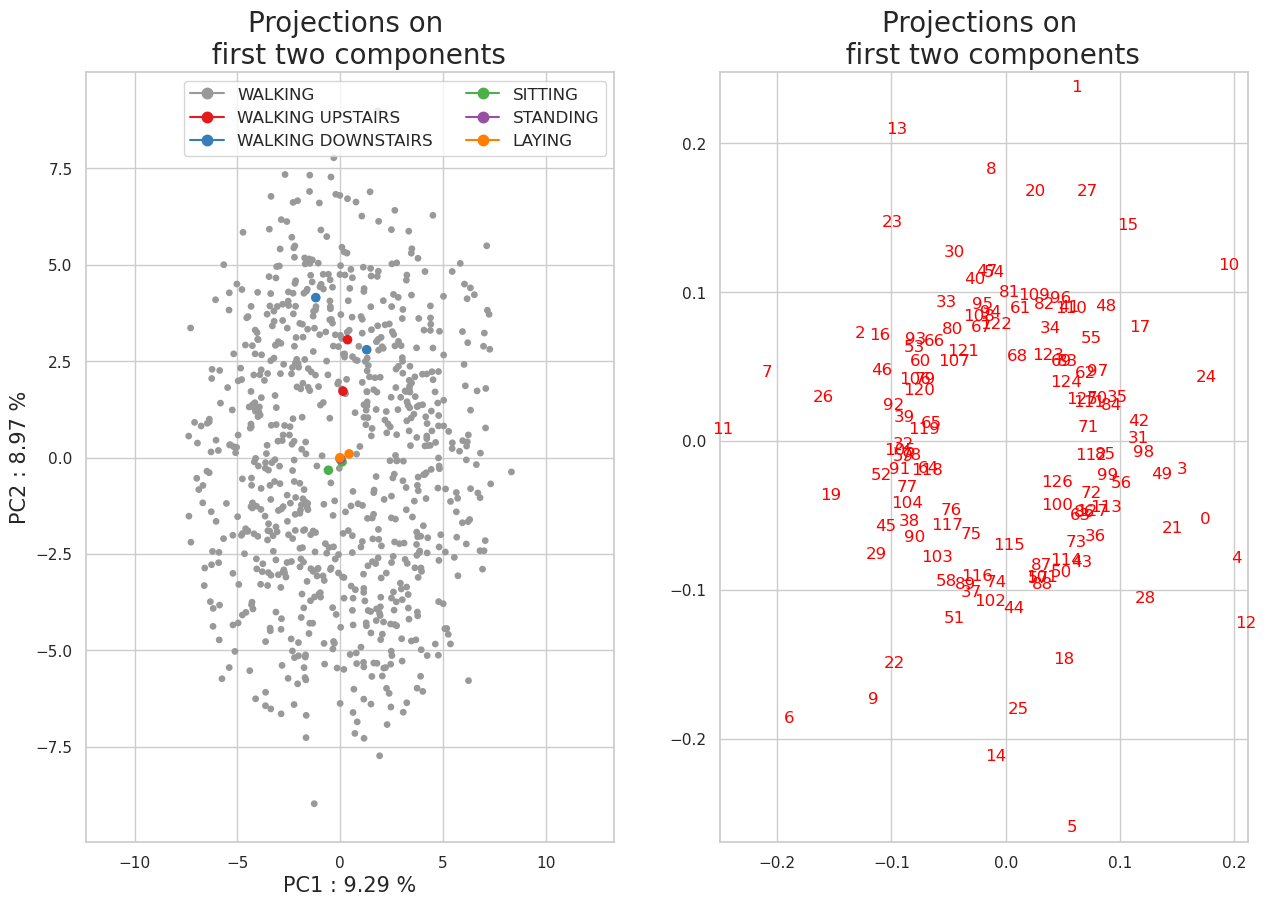

In [74]:
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_ond, acp, colors, markersizes, color_dic=COLOR_DIC)

L'acp sur la décomposition en ondelette ne permet pas d'isoler les anomalies sur la projection sur le plan PC1, PC2.

## 5.3 PCA of the wavelet coefficients from levels 1 to 4 :  

In [75]:
acp = sd.PCA()
X_acp_ondA4 = acp.fit_transform(sp.scale(CoeffA4))

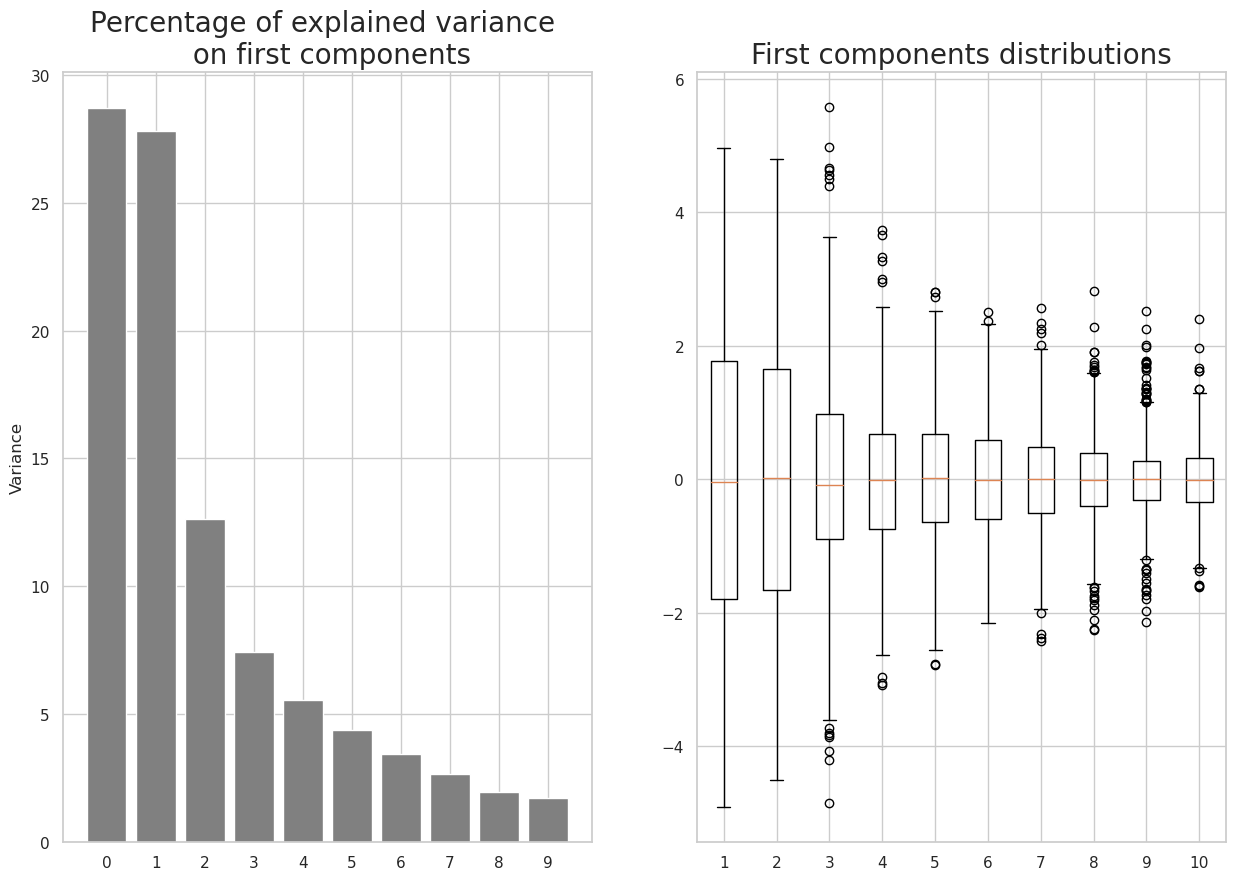

In [76]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_ondA4)

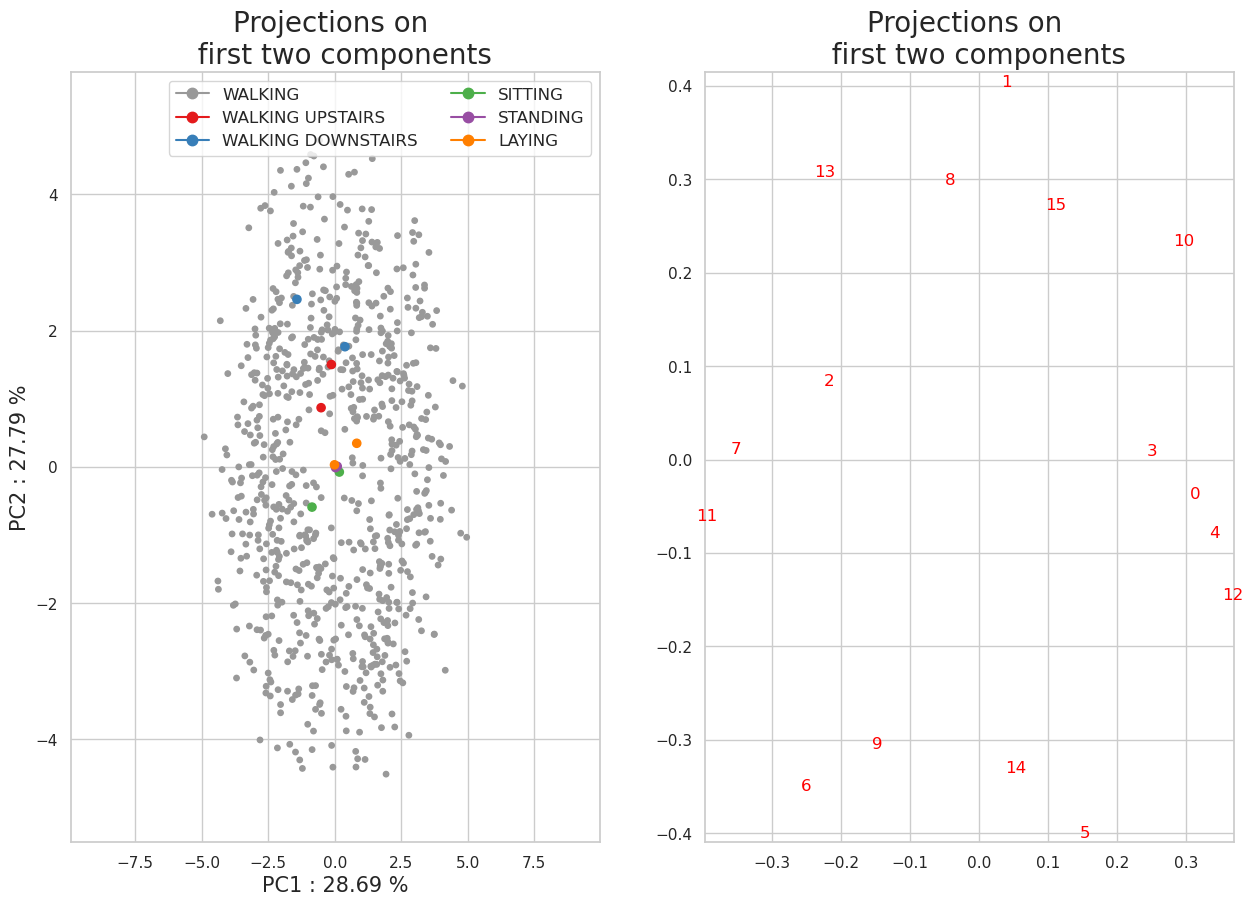

In [77]:
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_ondA4, acp, colors, markersizes, color_dic=COLOR_DIC)

**Q** Comment these results in the perspective of anomaly detection.

On applique ici la PCA sur les premiers coefficients d'ondelette (level 1 à 4). Ceci ne permet toujours de détecter les anomalies sur le plan PC1, PC2. 

Cependant, on observe que la variance est mieux projetée sur les premières composantes par rapport à précedemment. 

## 5.4 Hierarchical clustering

In [78]:
# hierarchical clustering sur tous les coeffs d'ondelette. 

Z = sch.linkage(Coeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             2        2         2      793                   2   
1             0        0         0        3                   0   
2             0        0         0        1                   0   
3             0        0         0        1                   0   
4             0        0         0        1                   0   
5             0        0         0        1                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

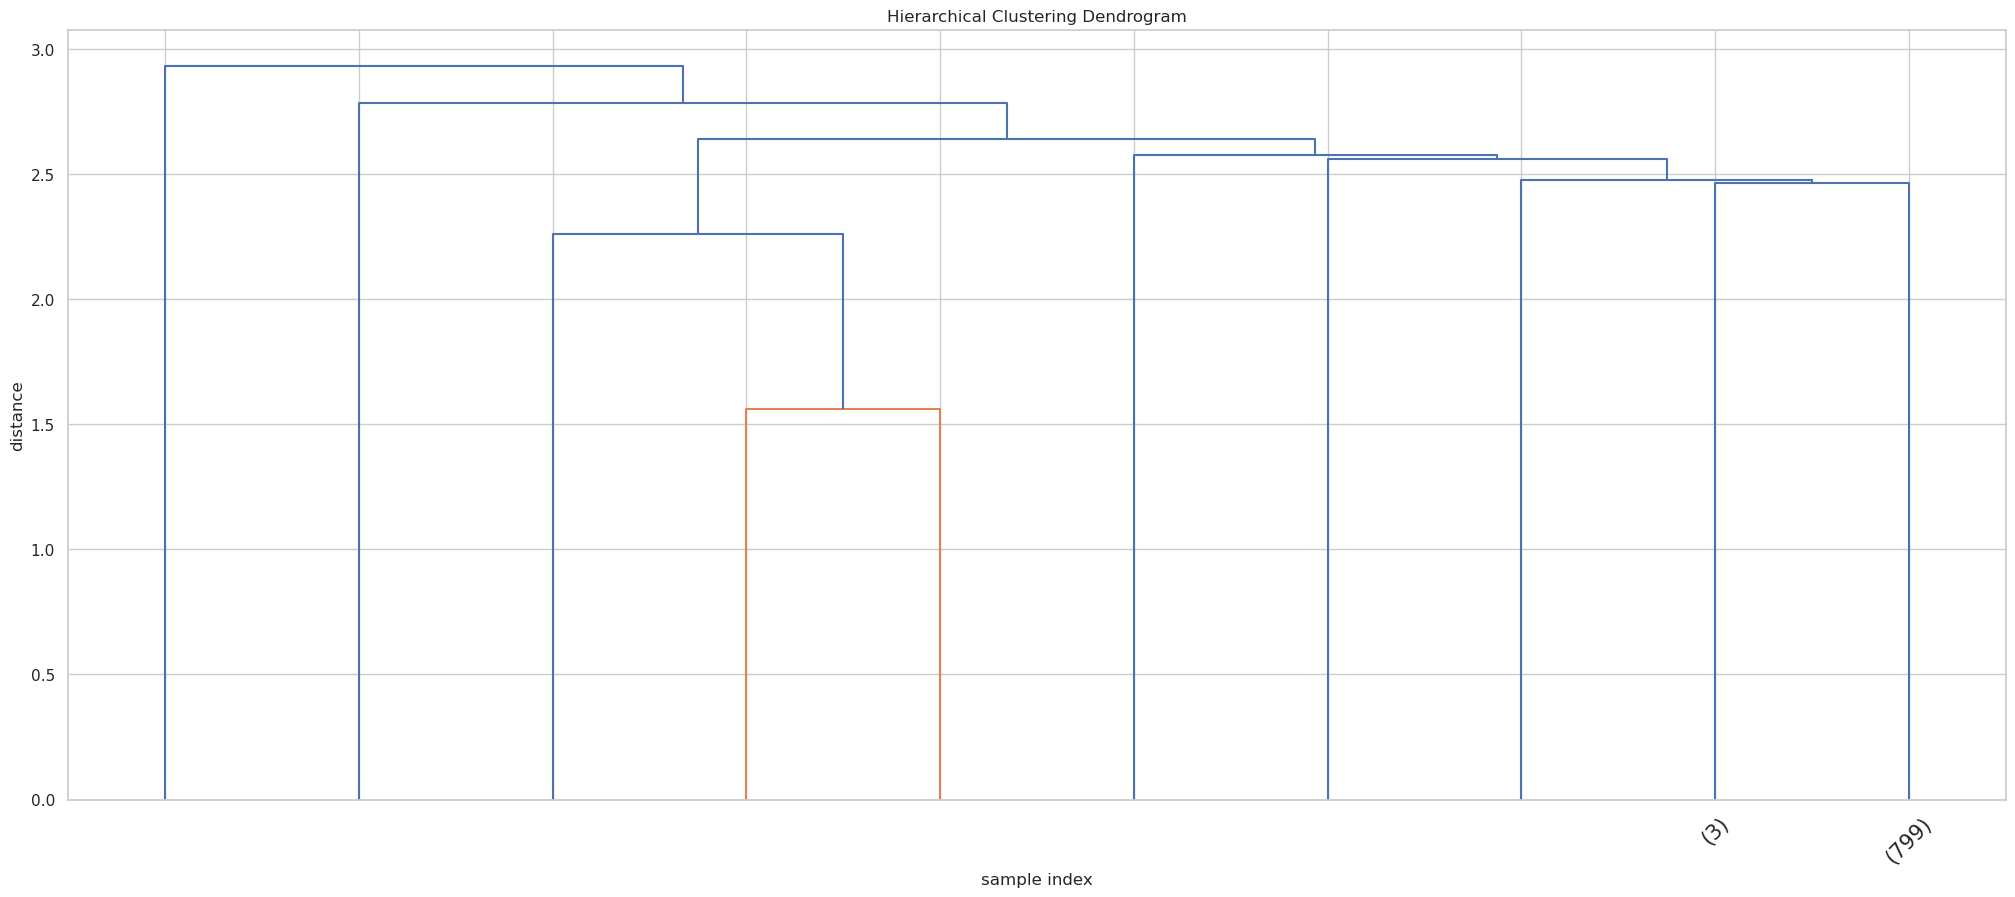

In [79]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

## 5.5 One class SVM

### 5.5.1 On all the coefficients

In [84]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

OCS.fit(Coeff)
pred = OCS.predict(Coeff)

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       51                   1   
 1            2        2         2      749                   1   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Do we get better results with thresholded coefficients? With the coefficients of level 1 to 4? 

non sauf pour la classe walking downstrairs qui est mieux discriminée. 

## 5.6 Local Outlier Factor

### 5.6.1 On the coefficients from  levels  1 to 4

In [81]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(CoeffA4)

CT_ond_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_ond_lof.pred, CT_ond_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

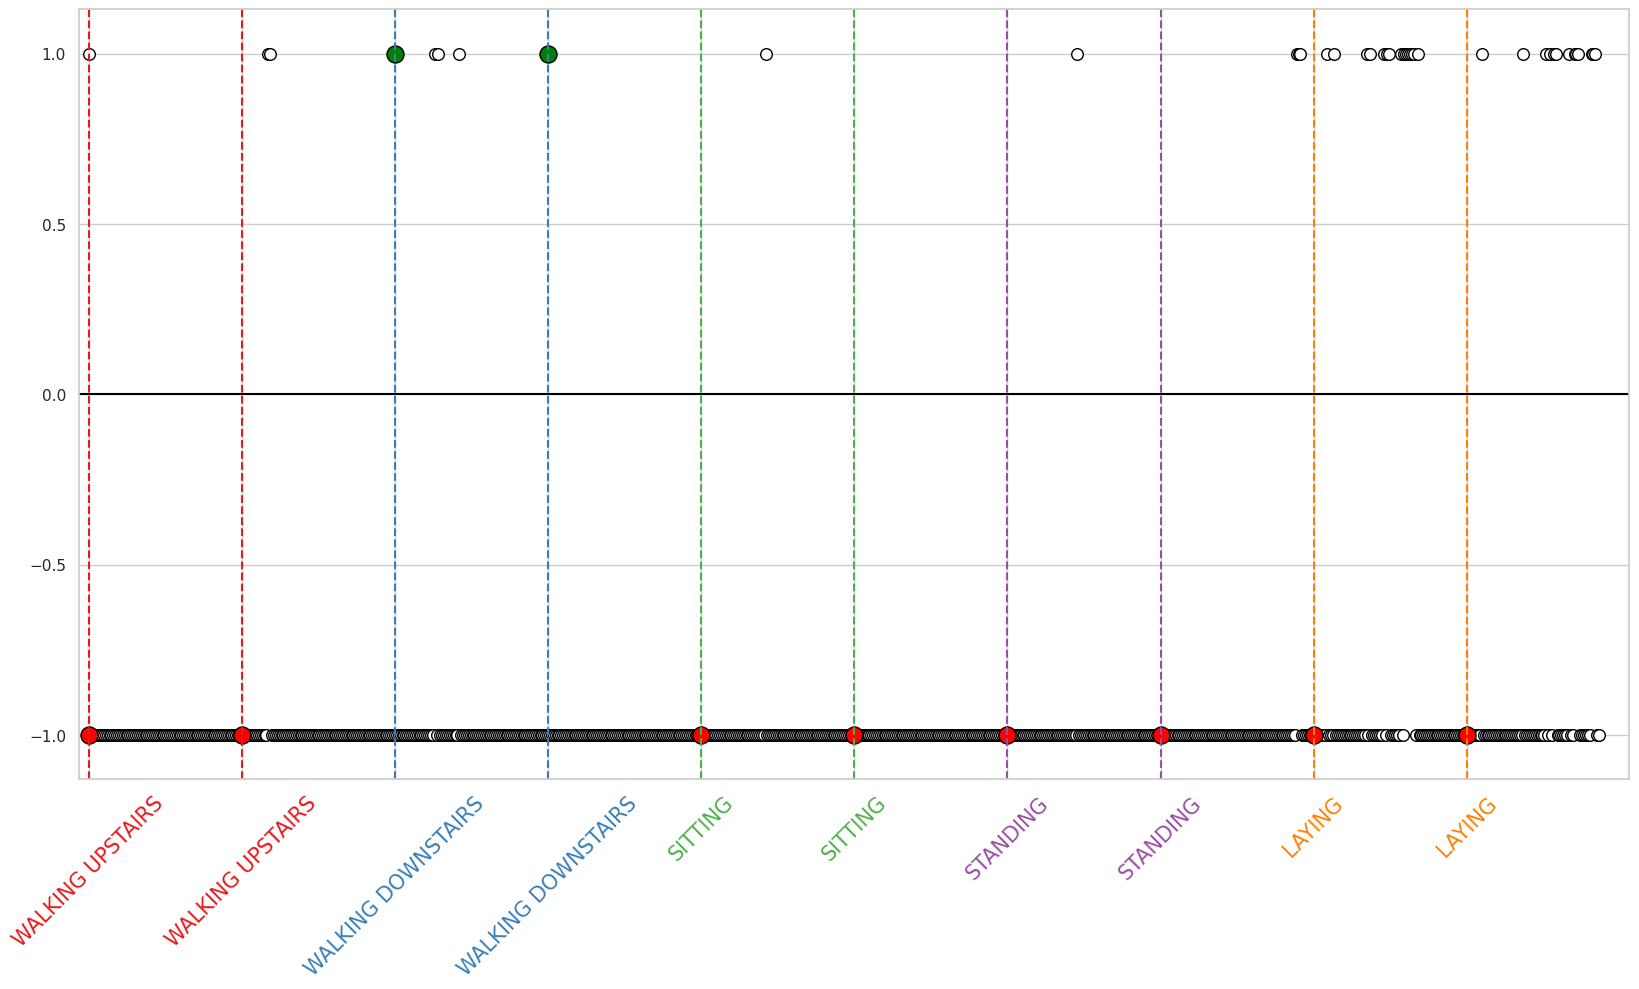

In [85]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_ond_lof, COLOR_DIC, normal_behaviour="WALKING")

**Q.** Do you get better results with all the coefficients? With the thresholded coefficients? With higher level coefficients?

Non :')

## 5.7 Isolation Forest

### 5.7.1 On all the coefficients

In [90]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)

clf.fit(Coeff)
y_pred = clf.predict(Coeff)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       41                   0   
 1            2        2         2      759                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Do we get better results with thresholded coefficients? With the coefficients of levels 1 to 4?

Les résultats sont identiques avec les coefficients des levels 1 à 4 ou tous les coefficients.

**Q.**We only worked on the acceleration in x. Does considering all the signals improve the results?

**Conclusion :** The anomaly detection methods that we have considered, applied on wavelet transformations of the raw signals, do not detect anomalies. In the next section, we will see if the Fourier transform allows to improve the results.

# 6. Anomaly detection with the FFT coefficients
## 6.1 Computation of the FFT coefficients

In [91]:
# FFT Coefficients : 

from scipy.fftpack import fft

isignal = 0
print(" signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

#print(amplitudefft)
#plt.plot(amplitudefft)

fftCoeff = []

for x in X_signal :
    
    mx=np.mean(x)
    x_centre=x-mx
   #Apply fast Fourier transform
    coeffsfft=np.abs(fft(x_centre))  
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)
        
fftCoeff = np.array(fftCoeff)

# Just keep half of the coefficients (they are then repeated symmetrically)

fftCoeff=fftCoeff[:,:64]
print(fftCoeff.shape)
print(np.sum(fftCoeff!=0))

 signal body_acc_x
(810, 64)
51816


## 6.2 PCA of the FFT coefficients

In [92]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(fftCoeff))


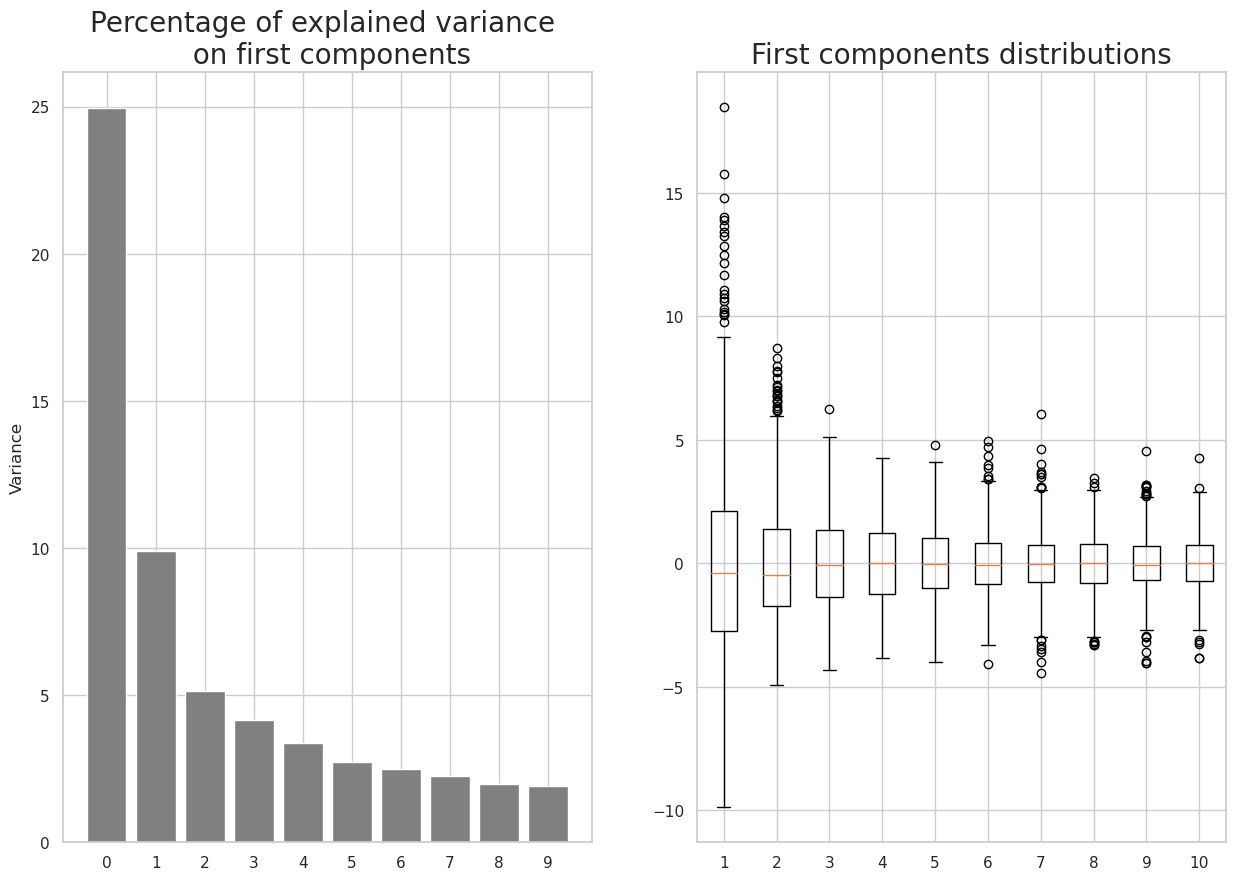

In [93]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_fft)

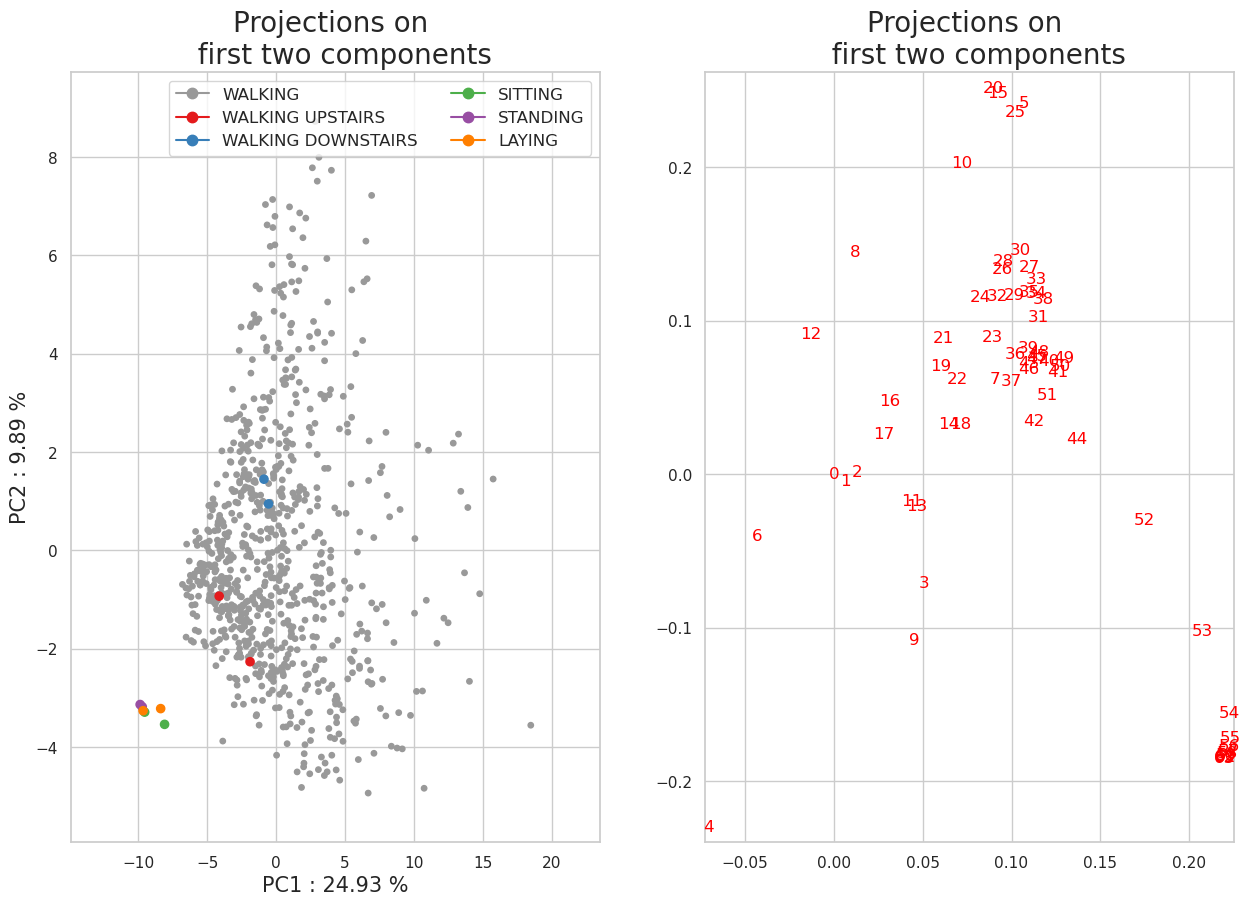

In [94]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_fft, acp, colors, markersizes, color_dic=COLOR_DIC)

**Q.** Which signals differ from the others? Is this consistent with what has been seen in the previous notebook?
Le signal qui diffère des autres est walking upstairs. Les autres anomalies sont mieux discriminées. 

## 6.3 Hierarchical clustering

In [95]:
Z = sch.linkage(fftCoeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             0        0         0      794                   2   
1             0        0         0        1                   0   
2             0        0         0        1                   0   
3             0        0         0        3                   0   
4             0        0         0        1                   0   
5             2        2         2        0                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

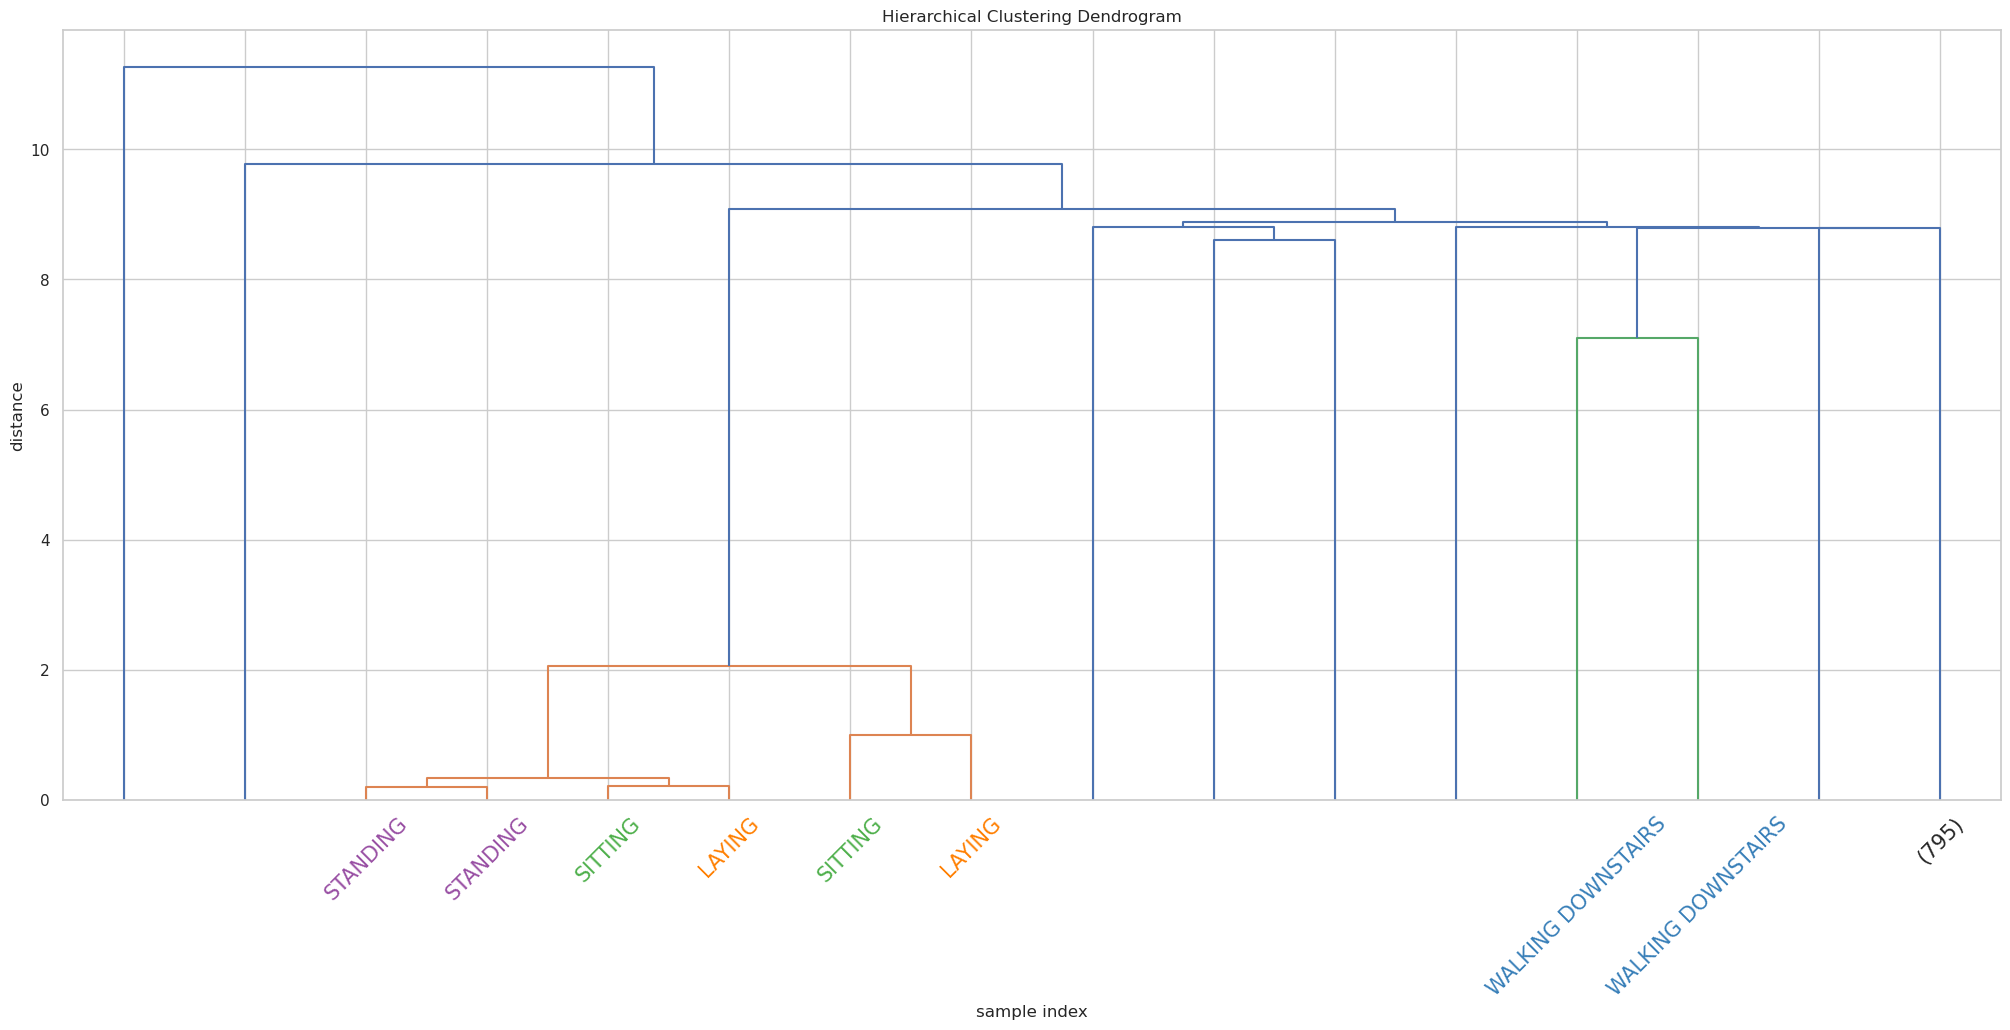

In [96]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

**Q** Comment the results. 

Bonne discrimination des classes immobiles mais pas des classes mobiles. 

## 6.4 One class SVM

In [108]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

OCS.fit(fftCoeff)
pred = OCS.predict(fftCoeff)

CT_FFT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_FFT_svm.pred, CT_FFT_svm.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       35                   2   
 1            0        0         0      765                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

In [109]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.3)

OCS.fit(fftCoeff)
pred = OCS.predict(fftCoeff)

CT_FFT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_FFT_svm.pred, CT_FFT_svm.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2      236                   2   
 1            0        0         0      564                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      2  
 1                      0

**Q.** Study the impact of the kernel and of the parameter nu.

Plus nu augmente, plus le modèle classes un nombre important d'observations comme étant des anomalies. Cela est positif pour la détection des données qui sont effecivement des anomalies (par exemple walking upstairs est discriminé pour nu=0.3), mais cela engendre aussi plus de faux positifs (walking considéré comme anomalie). 

Si on change le kernel, on obtient pas forcément les mêmes résultats. Par exemple, poly et linear donnent de moins bon résultats que rbf. 

## 6.5 Local Outlier Factor

In [119]:
contamination=0.05
metric = "euclidean"
n_neighbors = 9
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(fftCoeff)

CT_FFT_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_FFT_lof.pred, CT_FFT_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       31                   2   
 1            0        0         0      769                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      2  
 1                      0

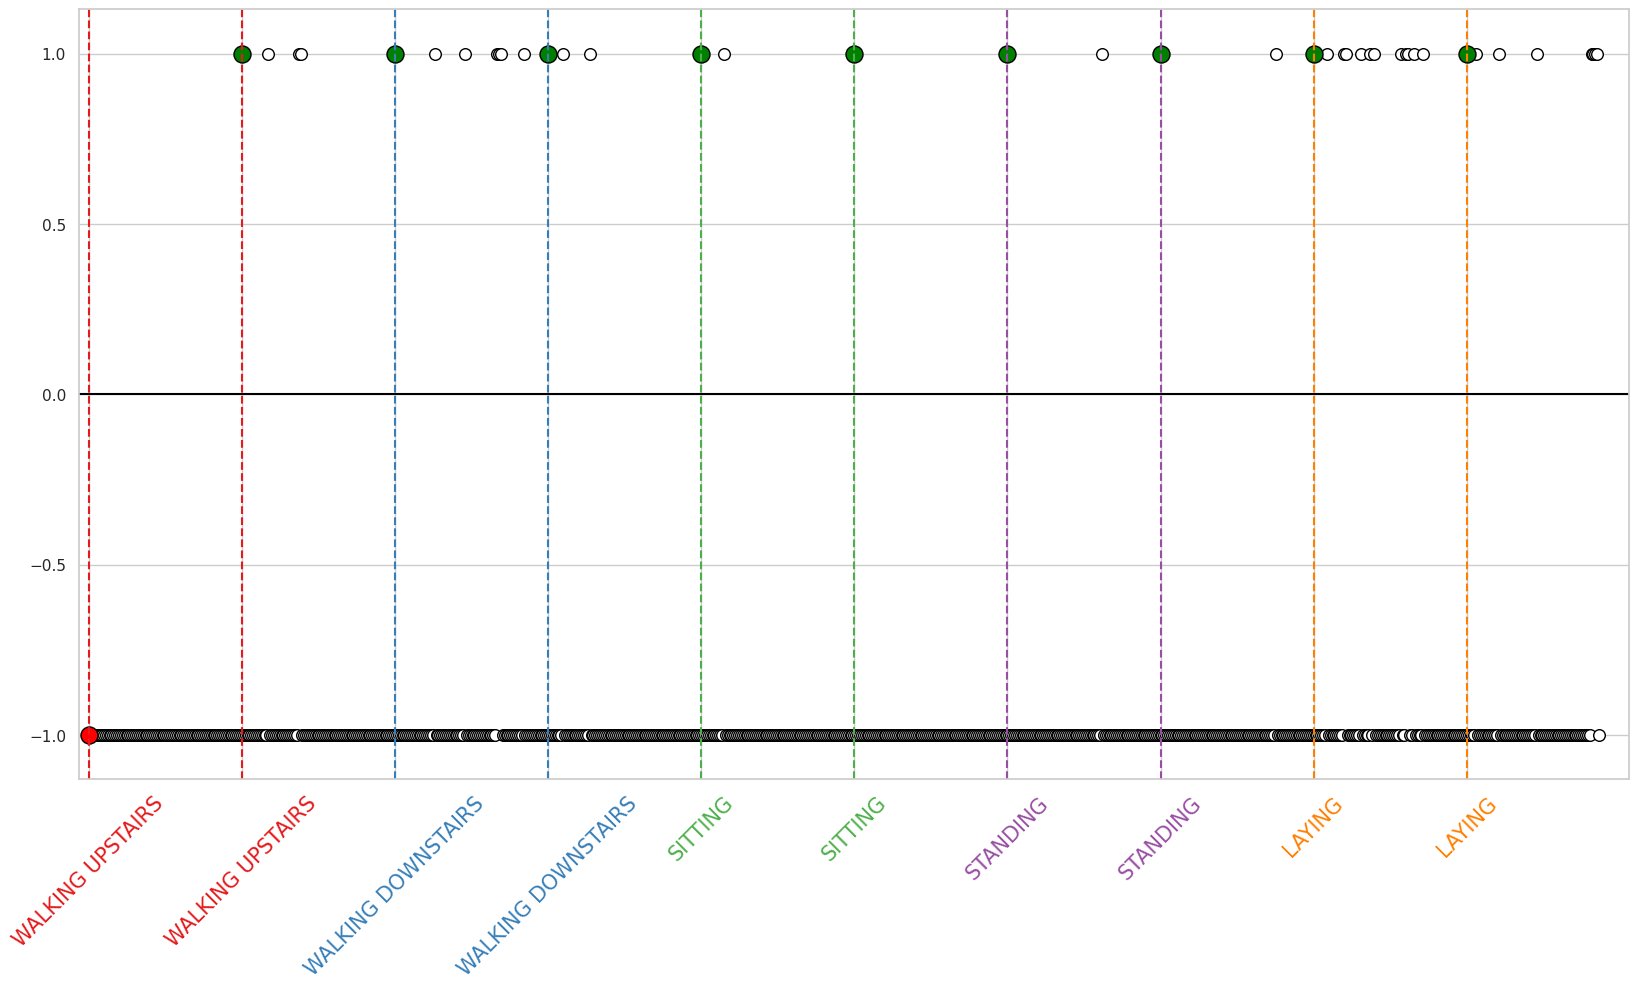

In [111]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_FFT_lof, COLOR_DIC, normal_behaviour="WALKING")


** Q.** Comment on the results and see the impact of the parameters. 

Contamination représente le taux de faux positifs. Plus on augmente sa valeur, plus l'algo va chercher à classifier un nombre important d'observations comme étant des anomalies. Cela entraine une meilleure discrimination des anomalies mais aussi plus de faux positifs. 

Si le nombre k de voisins est trop faible, l'algo ne va pas réussir à détecter les anomalies. Il faut trouver un nombre minimal suffisant qui fournisse une bonne discrimination, sinon le calcul de proximité entre les voisins n'est pas représentatif sur le jeu de données. Et d'un autre côté, il ne faut pas prendre trop de voisins, sinon ils sont tous trop éloignés les uns des autres. 

## 6.5 Isolation Forest

In [120]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)

clf.fit(fftCoeff)
y_pred = clf.predict(fftCoeff)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         2       39                   0   
 1            2        2         0      761                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2


## 6.7 Visualisation of the  LOF results

The LOF method is one of the most powerful whatever the type of "features" considered. The results of this method are visualized for the various cases considered in the notebook.


Text(0.5, 1.0, 'FFT coefficients')

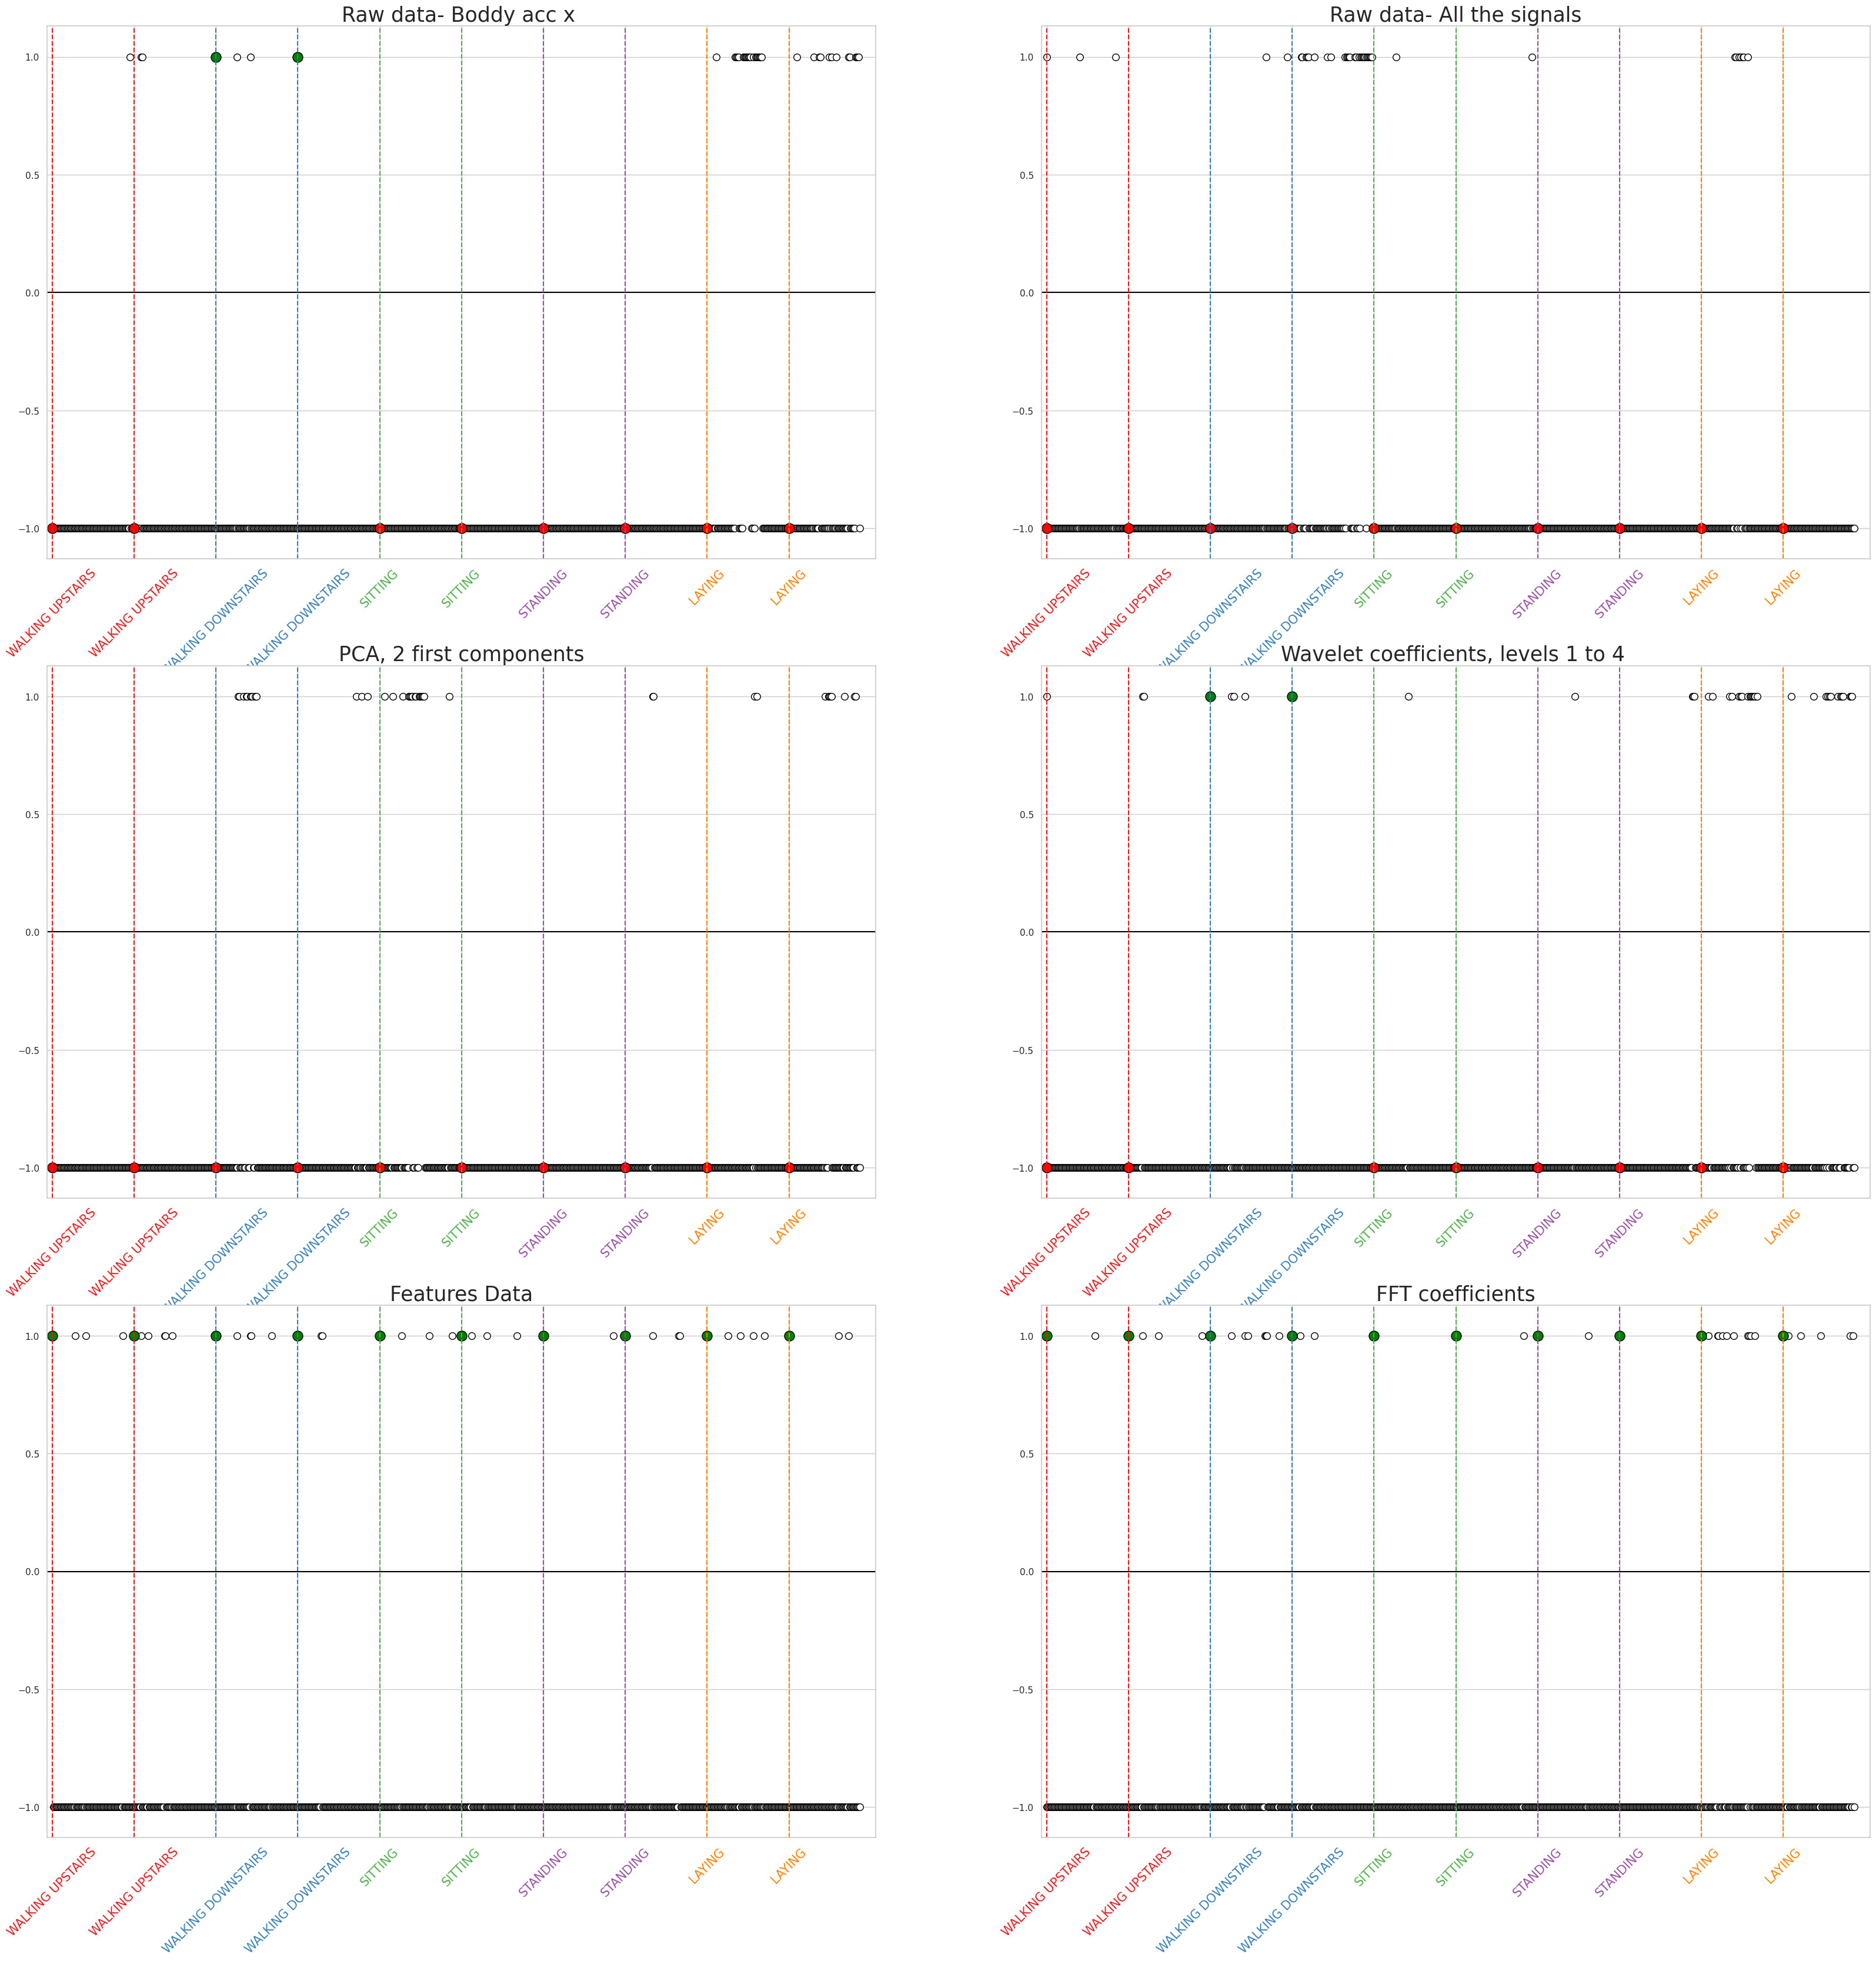

In [121]:
fig = plt.figure(figsize=(40,40))
ax = fig.add_subplot(3,2,1)
uil.plot_detection_result(fig, ax, CT_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Raw data- Boddy acc x ", fontsize=25)
ax = fig.add_subplot(3,2,2)
uil.plot_detection_result(fig, ax, CT_tous_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Raw data- All the signals", fontsize=25)
ax = fig.add_subplot(3,2,3)
uil.plot_detection_result(fig, ax, CT_ACP_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("PCA, 2 first components", fontsize=25)
ax = fig.add_subplot(3,2,4)
uil.plot_detection_result(fig, ax, CT_ond_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Wavelet coefficients, levels 1 to 4 ", fontsize=25)
ax = fig.add_subplot(3,2,5)
uil.plot_detection_result(fig, ax, CT_metier_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Features Data", fontsize=25)
ax = fig.add_subplot(3,2,6)
uil.plot_detection_result(fig, ax, CT_FFT_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("FFT coefficients", fontsize=25)

# 7. Exercise

Use a variational autoencoder on the signals to detect anomalies. You can either detect anomalies from the reconstruction error or use the features obtained from the VAE and apply the previous anomaly detection algorithms. 

In [260]:
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku

import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

In [261]:
nb_ST, len_ST, nb_features = X_train.shape
print(len_ST)
print(nb_ST)
print(nb_features)

128
7352
6


In [262]:
# network parameters
batch_size=100
intermediate_dim = 512
latent_dim = 2
epochs = 25

In [266]:
# Input layer
inputs = kl.Input(shape=(len_ST,nb_features), name='encoder_input')
# Dense layer from input layer
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
# Two dense layer that takes input from the same layer x
z_mean = kl.Dense(latent_dim, name='z_mean')(x)
z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)

In [267]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(len_ST, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = kl.Lambda(sampling, output_shape=(len_ST,latent_dim,), name='z')([z_mean, z_log_var])

In [268]:
# instantiate encoder model

encoder = km.Model(inputs, z, name='encoder')
encoder.summary()
#ku.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 6)]     0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 128, 512)     3584        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128, 2)       1026        dense_43[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 128, 2)       1026        dense_43[0][0]                   
____________________________________________________________________________________________

In [269]:
output_layer_shape = encoder.layers[-1].output_shape[1:]
output_layer_shape

(128, 2)

In [253]:
(len_ST,latent_dim,)

(128, 2)

In [270]:
latent_inputs = kl.Input(shape=(len_ST,latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim)(latent_inputs)
outputs = kl.Dense(nb_features, activation='relu')(x)

# instantiate decoder model
decoder = km.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
dense_44 (Dense)             (None, 128, 512)          1536      
_________________________________________________________________
dense_45 (Dense)             (None, 128, 6)            3078      
Total params: 4,614
Trainable params: 4,614
Non-trainable params: 0
_________________________________________________________________


In [271]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = km.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 6)]          0         
_________________________________________________________________
encoder (Functional)         (None, 128, 2)            5636      
_________________________________________________________________
decoder (Functional)         (None, 128, 6)            4614      
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________


In [272]:
# entrainement du VAE : 
reconstruction_loss = kloss.binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= len_ST
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [257]:
len_ST

128

In [273]:
vae.fit(X_train,
        epochs=40,
        batch_size=batch_size,
        validation_data=(X_test, None))

Epoch 1/40
74/74 [==============================] - 11s 141ms/step - loss: -436.5580 - val_loss: -3203.0183
Epoch 2/40
 6/74 [=>............................] - ETA: 9s - loss: -3226.9550 

KeyboardInterrupt: 

In [ ]:
X_test.shape

# 8. Conclusion

We have studied various methods for anomaly detection. On the *features* data, it is quite easy  to detect the anomalies. On the functional raw data, we have seen the importance of defining good "features" to highlight the anomalies: the methods of detection of anomalies applied to the raw signals or their wavelet transform, have certainly not been totally optimized but do not give good results in this case. On the other hand, the Fast Fourier Transform highlights the anomalies for these data. We can not draw a generality : on simulated telemetry data of the available notebook [here](https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/AnomalyDetection/Python-Anomaly-Detection.ipynb), the transformation onto a wavelet basis is relevant for the detection of anomalies for these functional data. It is therefore important to know the data and the type of anomalies that you want to detect.
